In [281]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [282]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import folium
import wordcloud as wc
from wordcloud import STOPWORDS
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
from nltk.collocations import *

In [283]:
# First file - april
path = r'gdrive/MyDrive/data/2019/april/'
filename = glob.glob(path + "/listings.csv")[0]
df_listings_april19 = pd.read_csv(filename)
df_april19 = df_listings_april19[['id', 'zipcode', 'transit', 'bedrooms', 'beds', 'review_scores_rating', 'number_of_reviews', 'neighbourhood', 'name',
    'latitude', 'longitude', 'last_review', 'instant_bookable', 'host_id', 'host_since', 'host_response_rate',
    'host_identity_verified', 'host_has_profile_pic', 'first_review', 'description', 'city', 'cancellation_policy',
    'bed_type', 'bathrooms', 'accommodates', 'amenities', 'room_type', 'property_type', 'price', 'availability_365', 'minimum_nights']]
# Insert manually a column 'month'at the beginning
df_april19.insert(0, 'month', 'april')


# Second file - febrouary
path = "gdrive/MyDrive/data/2019/febrouary/"
filename = glob.glob(path + "/listings.csv")[0]
df_listings_febrouary19 = pd.read_csv(filename)
df_febrouary19 = df_listings_febrouary19[['id', 'zipcode', 'transit', 'bedrooms', 'beds', 'review_scores_rating', 'number_of_reviews', 'neighbourhood', 'name',
    'latitude', 'longitude', 'last_review', 'instant_bookable', 'host_id', 'host_since', 'host_response_rate',
    'host_identity_verified', 'host_has_profile_pic', 'first_review', 'description', 'city', 'cancellation_policy',
    'bed_type', 'bathrooms', 'accommodates', 'amenities', 'room_type', 'property_type', 'price', 'availability_365', 'minimum_nights']]
# Insert manually a column 'month'at the beginning
df_febrouary19.insert(0, 'month', 'febrouary')


# Third file - march
path = "gdrive/MyDrive/data/2019/march/"
filename = glob.glob(path + "/listings.csv")[0]
df_listings_march19 = pd.read_csv(filename)
df_march19 = df_listings_march19[['id', 'zipcode', 'transit', 'bedrooms', 'beds', 'review_scores_rating', 'number_of_reviews', 'neighbourhood', 'name',
    'latitude', 'longitude', 'last_review', 'instant_bookable', 'host_id', 'host_since', 'host_response_rate',
    'host_identity_verified', 'host_has_profile_pic', 'first_review', 'description', 'city', 'cancellation_policy',
    'bed_type', 'bathrooms', 'accommodates', 'amenities', 'room_type', 'property_type', 'price', 'availability_365', 'minimum_nights']]
# Insert manually a column 'month'at the beginning
df_march19.insert(0, 'month', 'march')

# Concatenate the three DataFrames
df_train_2019 = pd.concat([df_april19, df_febrouary19, df_march19], ignore_index=True)
# print(df_train_2019)
# df_train_2019.to_csv('train_2019.csv', index=False)

<ipython-input-283-b694636efe42>:4: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df_listings_april19 = pd.read_csv(filename)
<ipython-input-283-b694636efe42>:16: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df_listings_febrouary19 = pd.read_csv(filename)
<ipython-input-283-b694636efe42>:28: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df_listings_march19 = pd.read_csv(filename)


In [284]:
#Starting to clean the data from null values -> by dropping the null values that are strings
# and replacing the null values that are numbers with the AVG VALUE of that column

# Get the names of numeric columns
number_columns = df_train_2019.select_dtypes(include=[np.number]).columns

# Get the names of string (object) columns
string_columns = df_train_2019.select_dtypes(include=[object]).columns

# Drop rows with missing values in string columns
df_train_2019.dropna(subset=string_columns, inplace=True)

# Replace missing values in number columns with the column mean in the original DataFrame
for col in number_columns:
    df_train_2019[col].replace(np.nan, df_train_2019[col].mean(), inplace=True)

# Replace all extreme values from column 'minimum_nights' and 'price'
df_train_2019.loc[df_train_2019['minimum_nights'] > 365, 'minimum_nights'] = df_train_2019['minimum_nights'].median()

# Clean the column 'price' and convert to float
df_train_2019['price_float'] = df_train_2019['price'].replace('[\$,]', '', regex=True).str.replace('.00', '').astype(float)
# print(df_train_2019['price_float'])

# Track Outliers and filtered them out for price and bedrooms column
df_temp_price = df_train_2019.copy()
df_temp_price['x-Mean'] = abs(df_temp_price['price_float'] - df_temp_price['price_float'].mean())
df_temp_price['1.96*std'] = 1.96*df_temp_price['price_float'].std()
df_train_2019['Outlier'] = abs(df_temp_price['price_float'] - df_temp_price['price_float'].mean()) > 1.96*df_temp_price['price_float'].std()
df_train_2019.loc[df_train_2019['Outlier'] == True, 'price_float'] = df_temp_price['1.96*std']

df_train_2019 = df_train_2019[df_train_2019['Outlier'] == False].copy()
df_train_2019.drop(columns=['Outlier'], inplace=True) # Remove 'Outlier' column

df_train_2019_copy = df_train_2019.copy()
# df_train_2019.to_csv('train_2019.csv', index=False)

The most usual room type is: Entire home/apt


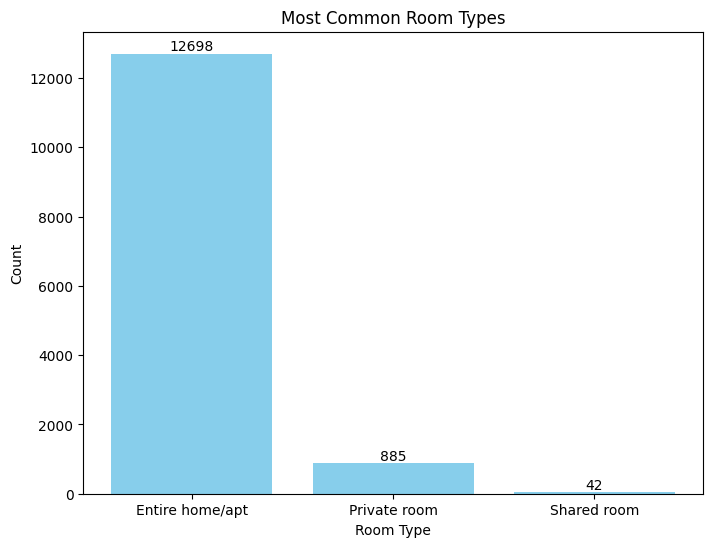

In [285]:
# 1.1 Find the most common room type

import matplotlib.pyplot as plt

# print(df_train_2019['room_type'].value_counts())

most_usual_room_type = df_train_2019['room_type'].value_counts().idxmax()

print("The most usual room type is:", most_usual_room_type)

room_type_counts = df_train_2019['room_type'].value_counts()

plt.figure(figsize=(8,6))
bars = plt.bar(room_type_counts.index, room_type_counts.values, color='skyblue')

plt.xlabel('Room Type')
plt.ylabel('Count')
plt.title('Most Common Room Types')

# Add the exact numbers on top of the bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2.0, bar.get_height(), int(bar.get_height()), ha='center', va='bottom')

plt.show()

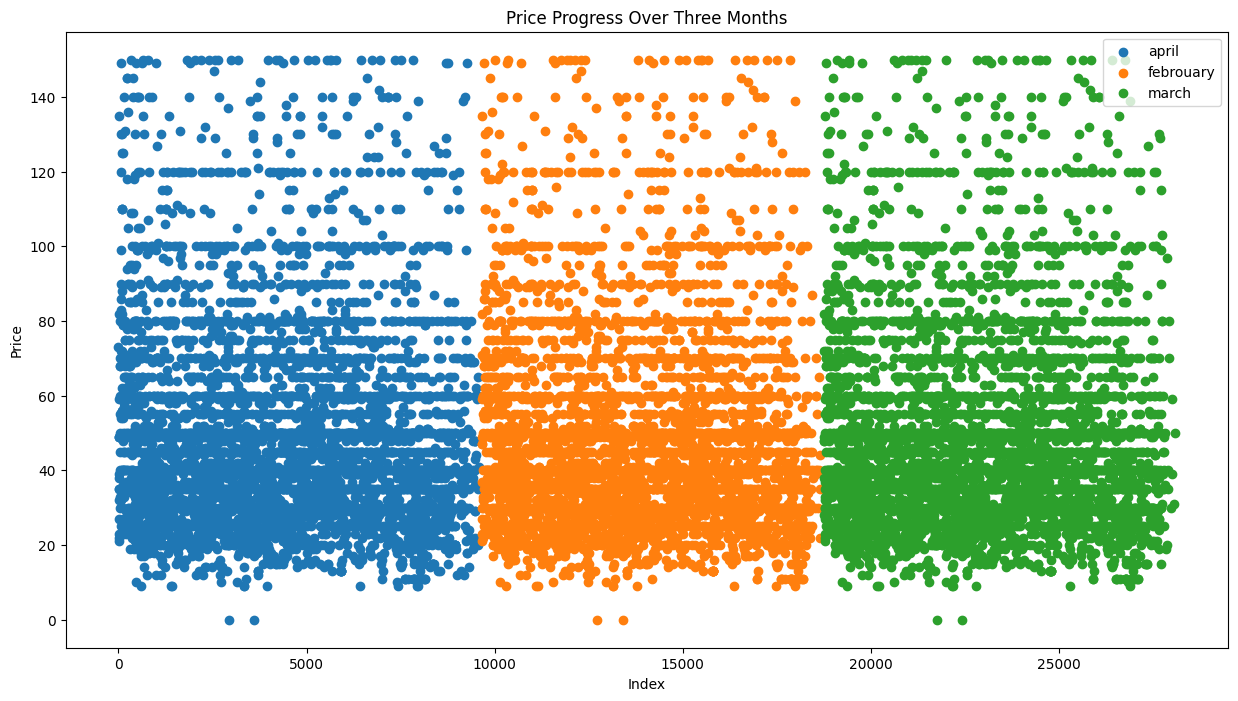

In [286]:
# 1.2 Graph that show the progress of prices in the last 3 months

# df_train_2019_copy_1_2 = df_train_2019.copy()

# This graph hsa a color for each month

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15,8))

# Get unique months
months = df_train_2019_copy['month'].unique()

# For each month
for month in months:
    data = df_train_2019_copy[df_train_2019_copy['month'] == month]
    # Trying different plots
    ax.scatter(data.index, data['price_float'], label=month)
    # ax.plot(data.index, data['price_float'], label=month)
    # ax.hist(data.index)

ax.set_title('Price Progress Over Three Months')
ax.set_xlabel('Index')
ax.set_ylabel('Price')

ax.legend()

plt.show()

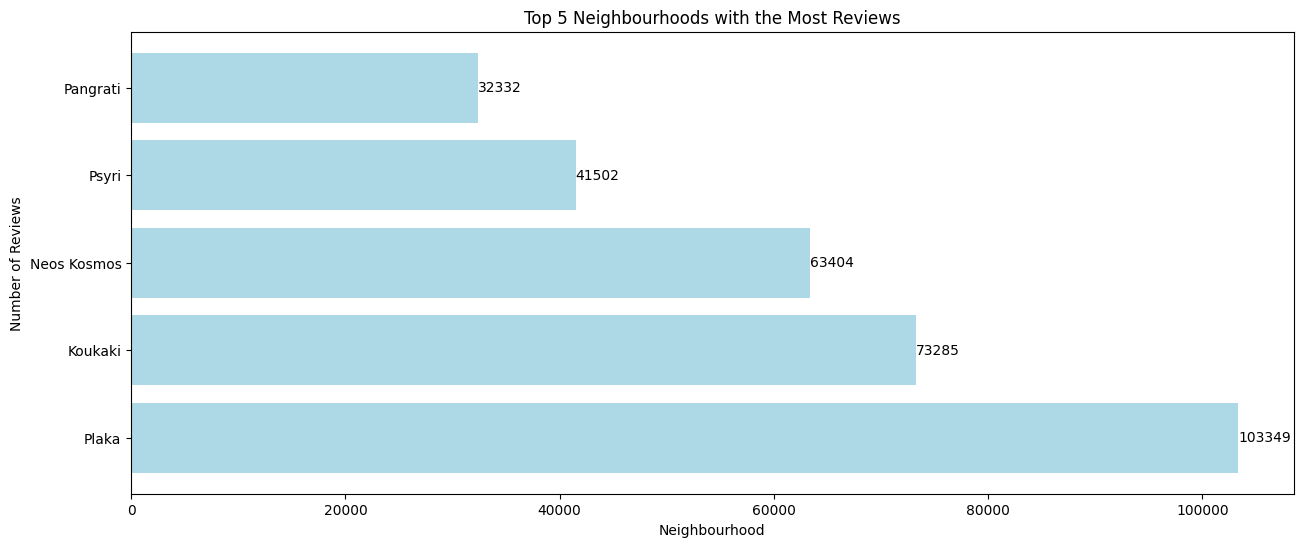

In [287]:
# 1.3 Calculate the top 5 neighbourhoods with the most reviews

# Group by 'neighbourhood' and calculate the sum of 'number_of_reviews'
neighbourhood_reviews = df_train_2019_copy.groupby('neighbourhood')['number_of_reviews'].sum()

# Sort by number of reviews and select the top 5 neighbourhoods
top_5_neighbourhoods = neighbourhood_reviews.sort_values(ascending=False).head(5)

# print(top_5_neighbourhoods)

plt.figure(figsize=(15,6))
bars = plt.barh(top_5_neighbourhoods.index, top_5_neighbourhoods.values, color='lightblue')

plt.xlabel('Neighbourhood')
plt.ylabel('Number of Reviews')
plt.title('Top 5 Neighbourhoods with the Most Reviews')

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, str(int(bar.get_width())), va='center', ha='left')

plt.show()

The neighbourhood with the most listings is: Plaka


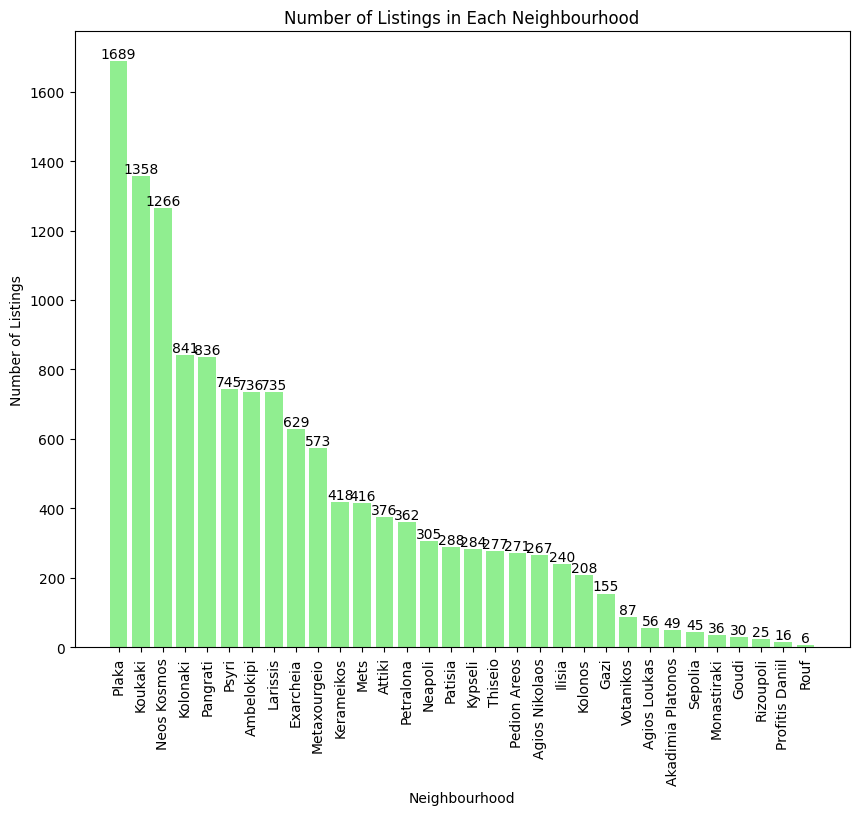

In [288]:
# 1.4 Find the neighbourhood with the most listing entries

# Count the number of listings in each neighbourhood
neighbourhood_counts = df_train_2019_copy['neighbourhood'].value_counts()
# print(neighbourhood_counts)

# Get the top neighbourhood
top_neighbourhood = neighbourhood_counts.idxmax()

print("The neighbourhood with the most listings is:", top_neighbourhood)

plt.figure(figsize=(10,8))
bars = plt.bar(neighbourhood_counts.index, neighbourhood_counts.values, color='lightgreen')

plt.xticks(rotation=90)
plt.xlabel('Neighbourhood')
plt.ylabel('Number of Listings')
plt.title('Number of Listings in Each Neighbourhood')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2.0, bar.get_height(), int(bar.get_height()), ha='center', va='bottom')

plt.show()

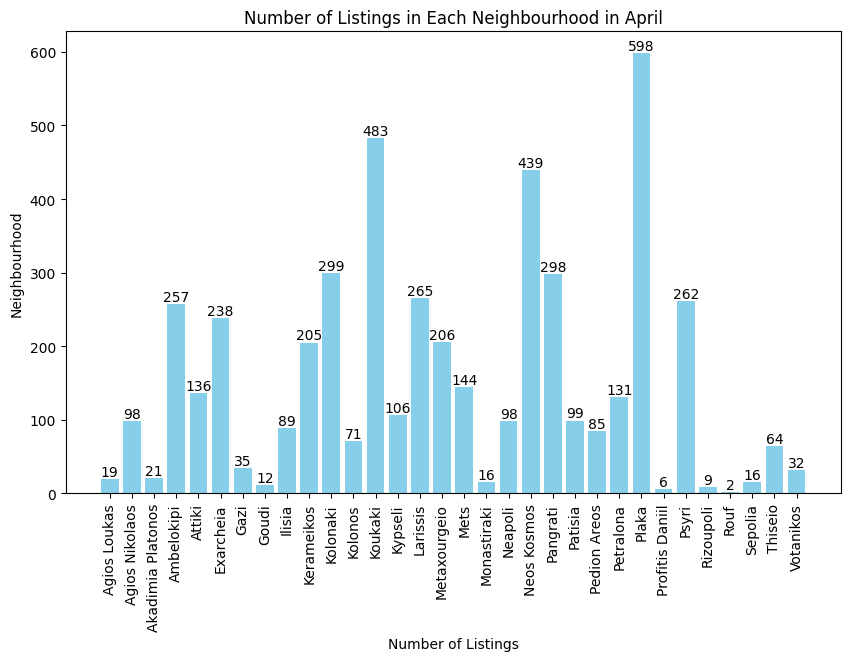

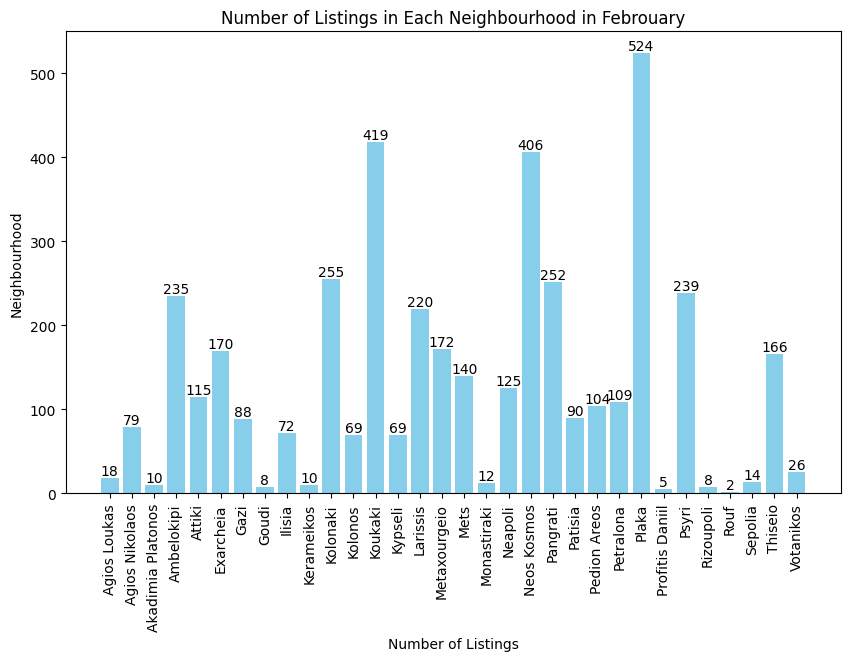

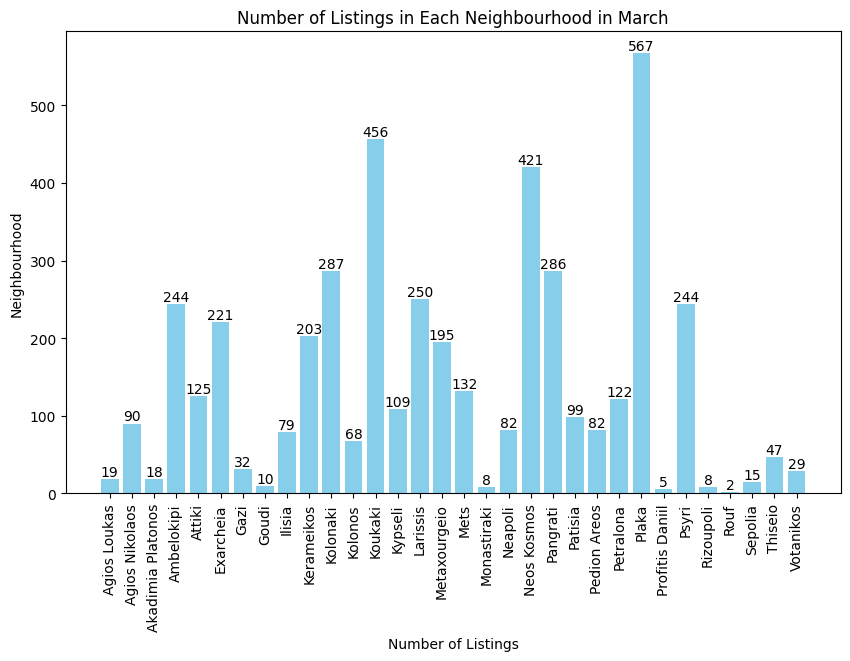

In [289]:
# 1.5 Find the listing entries by neighbourhood and by month

# Group by 'neighbourhood' and 'month', and count the number of listings
listing_counts = df_train_2019_copy.groupby(['neighbourhood', 'month']).size()

# For each month
for month in df_train_2019_copy['month'].unique():
    # Filter the data for the month
    data = listing_counts.reset_index()
    data = data[data['month'] == month]

    plt.figure(figsize=(10,6))
    bars = plt.bar(data['neighbourhood'], data[0], color='skyblue')

    plt.xlabel('Number of Listings')
    plt.xticks(rotation=90)
    plt.ylabel('Neighbourhood')
    plt.title(f'Number of Listings in Each Neighbourhood in {month.capitalize()}')

    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), int(bar.get_height()), ha='center', va='bottom')

    plt.show()

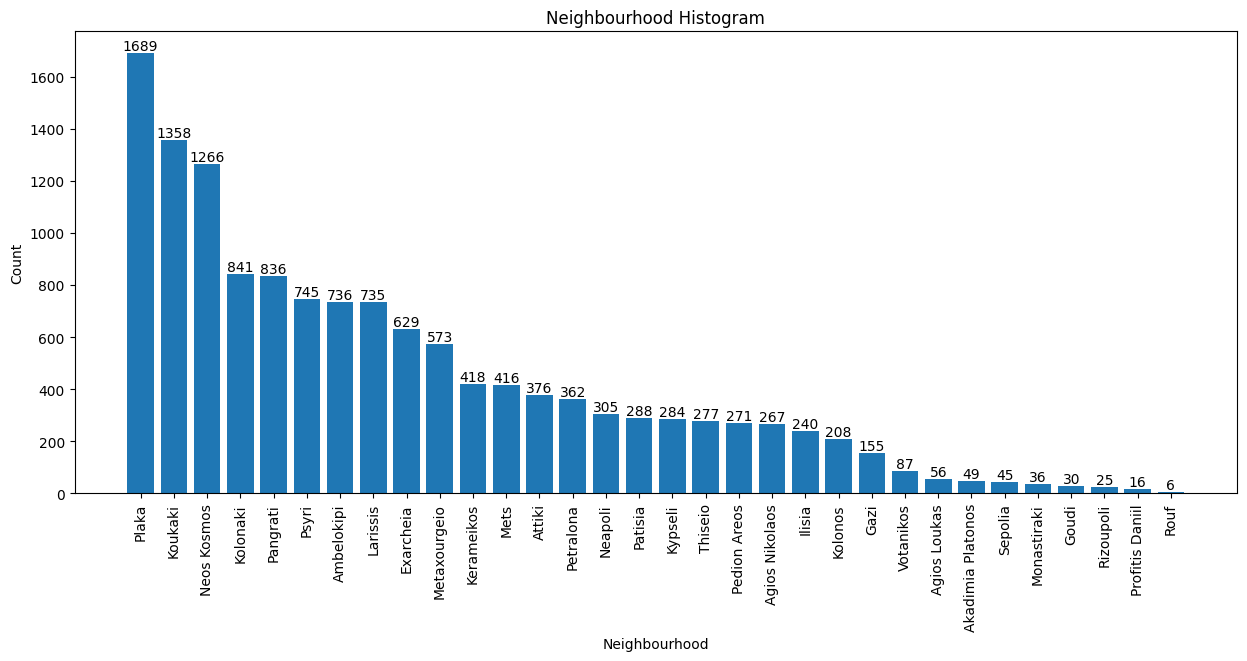

In [290]:
# 1.6 Histogram of 'neighbourhood'

# import matplotlib.pyplot as plt           # already imported above

counts = df_train_2019_copy['neighbourhood'].value_counts()

plt.figure(figsize=(15,6))
bars = plt.bar(counts.index, counts.values)

plt.xticks(rotation=90)
plt.title('Neighbourhood Histogram')
plt.xlabel('Neighbourhood')
plt.ylabel('Count')

for i in range(len(counts)):
    plt.text(counts.index[i], counts.values[i], str(counts.values[i]), ha='center', va='bottom')

plt.show()

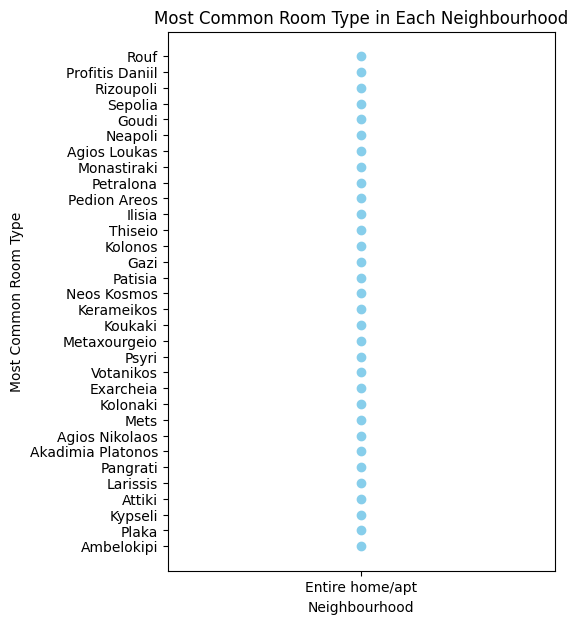

In [291]:
# 1.7 Find the most common room_type in each neighbourhood

# import matplotlib.pyplot as plt

# Group the data by 'neighbourhood' and 'room_type'
grouped = df_train_2019_copy.groupby(['neighbourhood', 'room_type']).size()

# Create an empty dictionary to store the most common room type in each neighbourhood
most_common_room_type = {}

# For each neighbourhood
for neighbourhood in df_train_2019_copy['neighbourhood'].unique():
    # Get the room type with the largest count
    most_common = grouped[neighbourhood].idxmax()
    # Add it to the dictionary
    most_common_room_type[neighbourhood] = most_common

# Convert the dictionary to lists for easier plotting
neighbourhoods = list(most_common_room_type.keys())
room_types = list(most_common_room_type.values())

fig, ax = plt.subplots(figsize=(5,7))

ax.scatter(room_types, neighbourhoods, color='skyblue')

ax.set_xlabel('Neighbourhood')
ax.set_ylabel('Most Common Room Type')
ax.set_title('Most Common Room Type in Each Neighbourhood')

plt.show()


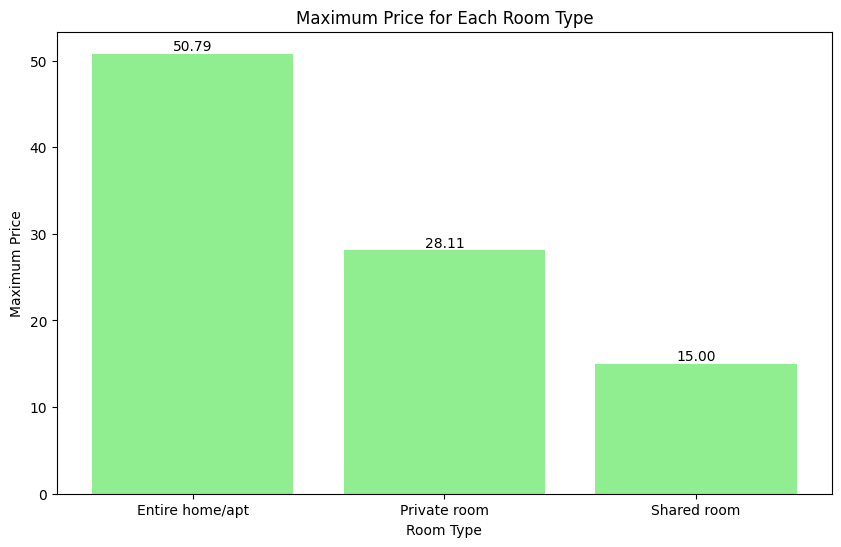

In [292]:
# 1.8 Find the most expensive room type -> changed after cleaning the data and using mean()

# Group by 'room_type' and find the maximum price for each group
max_prices = df_train_2019_copy[['room_type', 'price_float']].copy().groupby('room_type')['price_float'].mean()

plt.figure(figsize=(10,6))
plt.bar(max_prices.index, max_prices.values, color='lightgreen')
plt.xlabel('Room Type')
plt.ylabel('Maximum Price')
plt.title('Maximum Price for Each Room Type')
for i in range(len(max_prices)):
  plt.text(max_prices.index[i], max_prices.values[i], '{:.2f}'.format(max_prices.values[i]), ha='center', va='bottom')

In [293]:
# 1.9 #
# Filled for 2023

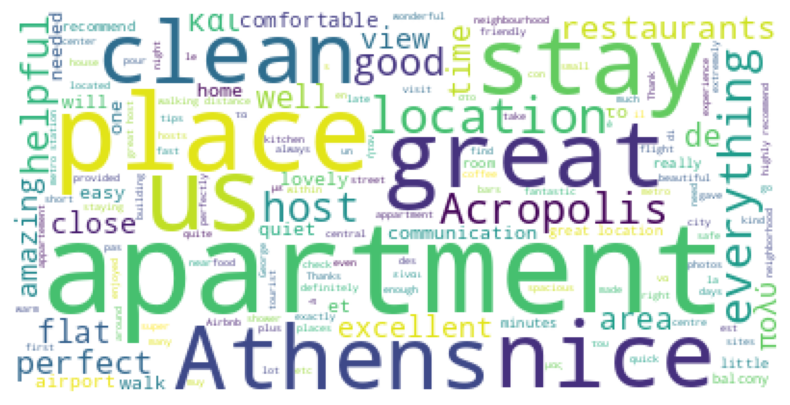

In [294]:
# 1.10a Make different wordclouds

import glob
import matplotlib.font_manager

# Word Cloud for comments of 2019
path = "gdrive/MyDrive/data/2019/febrouary/"
filename = glob.glob(path + "/reviews.csv")[0]
df_reviews_febrouary19 = pd.read_csv(filename)

path = "gdrive/MyDrive/data/2019/march/"
filename = glob.glob(path + "/reviews.csv")[0]
df_reviews_march19 = pd.read_csv(filename)

path = "gdrive/MyDrive/data/2019/april/"
filename = glob.glob(path + "/reviews.csv")[0]
df_reviews_april19 = pd.read_csv(filename)

# Create an one-column dataframe for comments of 2019
df_comments_febrouary19 = df_reviews_febrouary19['comments']
df_comments_march19 = df_reviews_march19['comments']
df_comments_april19 = df_reviews_april19['comments']

df_comments_19 = pd.concat([df_comments_febrouary19, df_comments_march19, df_comments_april19])
df_sample_comments_19 = df_comments_19.sample(200)
comments_text_19 = df_sample_comments_19.str.cat()
comments_text_19 = comments_text_19.replace("<br/>", "")
# print(comments_text_19)

# font_path = matplotlib.font_manager.findfont('DejaVu Sans')
# wcloud_comments_19 = wc.WordCloud(width=400, height=200, background_color='white', font_path="arial/arial.ttf",normalize_plurals=False).generate(comments_text_19)
wcloud_comments_19 = wc.WordCloud(width=400, height=200, background_color='white', normalize_plurals=False).generate(comments_text_19)

plt.figure(figsize=(10, 5))
plt.imshow(wcloud_comments_19)
plt.axis('off')
plt.show()

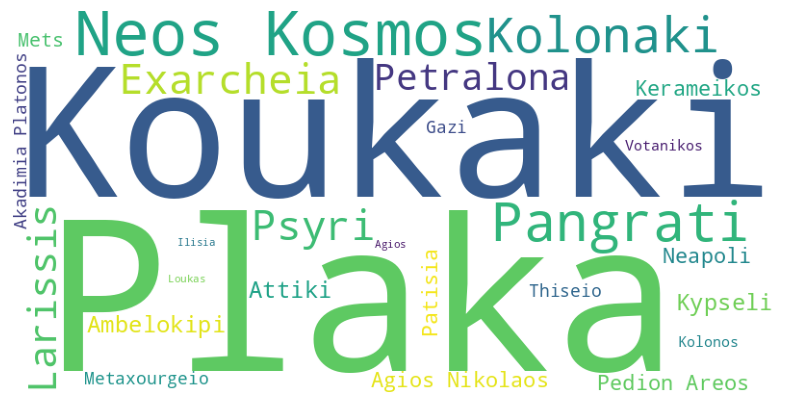

In [295]:
# 1.10b wordcloud for 'neighbourhood'

df_neighbourhoods_19 = df_train_2019_copy['neighbourhood'].str.replace(' ', '-')
df_neighbourhoods_sample_19 = df_neighbourhoods_19.sample(200)
neighbourhoods_text_19 = df_neighbourhoods_sample_19.str.cat(sep=' ')

wcloud_neighbourhood_19 = wc.WordCloud(width=800, height=400, background_color='white', normalize_plurals=False).generate(neighbourhoods_text_19)

plt.figure(figsize=(10, 5))
plt.imshow(wcloud_neighbourhood_19)
plt.axis('off')
plt.show()

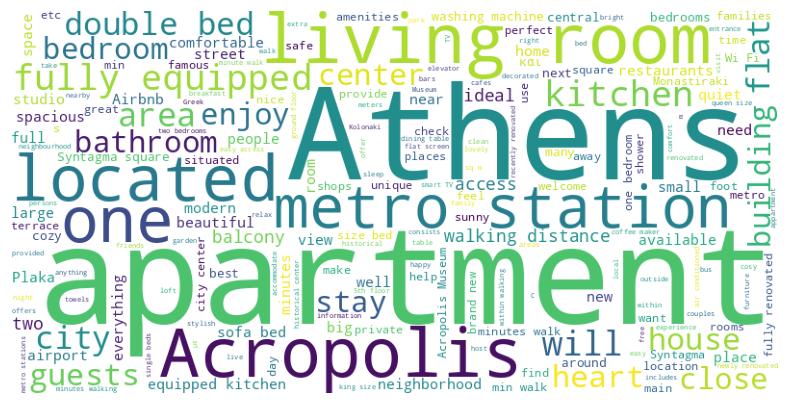

In [296]:
# 1.10c wordcloud for 'description'

df_descriptions_sample_19 = df_train_2019_copy['description'].sample(1000)
descriptions_text_19 = " ".join(description for description in df_descriptions_sample_19)

wcloud_description_19 = wc.WordCloud(width=800, height=400, background_color='white', normalize_plurals=False).generate(descriptions_text_19)

plt.figure(figsize=(10, 5))
plt.imshow(wcloud_description_19)
plt.axis('off')
plt.show()

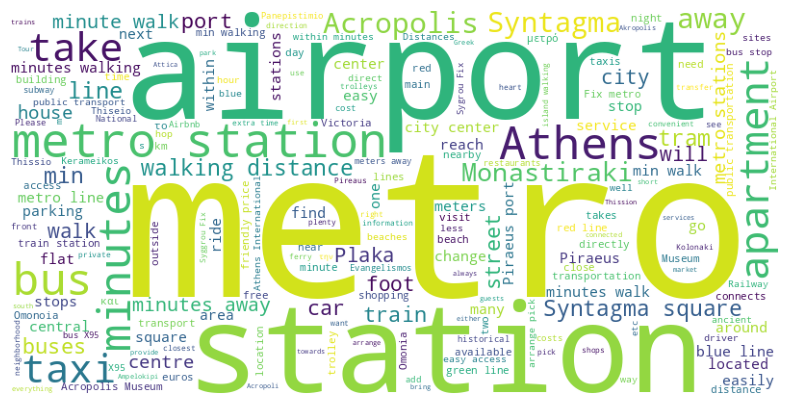

In [297]:
# 1.10d wordcloud for 'transit'

df_transit_19 = df_train_2019_copy['transit'].str.replace(' ', '-')
df_transit_sample_19 = df_transit_19.sample(200)
transit_text_19 = df_transit_sample_19.str.cat(sep=' ')

wcloud_transit_19 = wc.WordCloud(width=800, height=400, background_color='white', normalize_plurals=False).generate(transit_text_19)

plt.figure(figsize=(10, 5))
plt.imshow(wcloud_transit_19)
plt.axis('off')
plt.show()

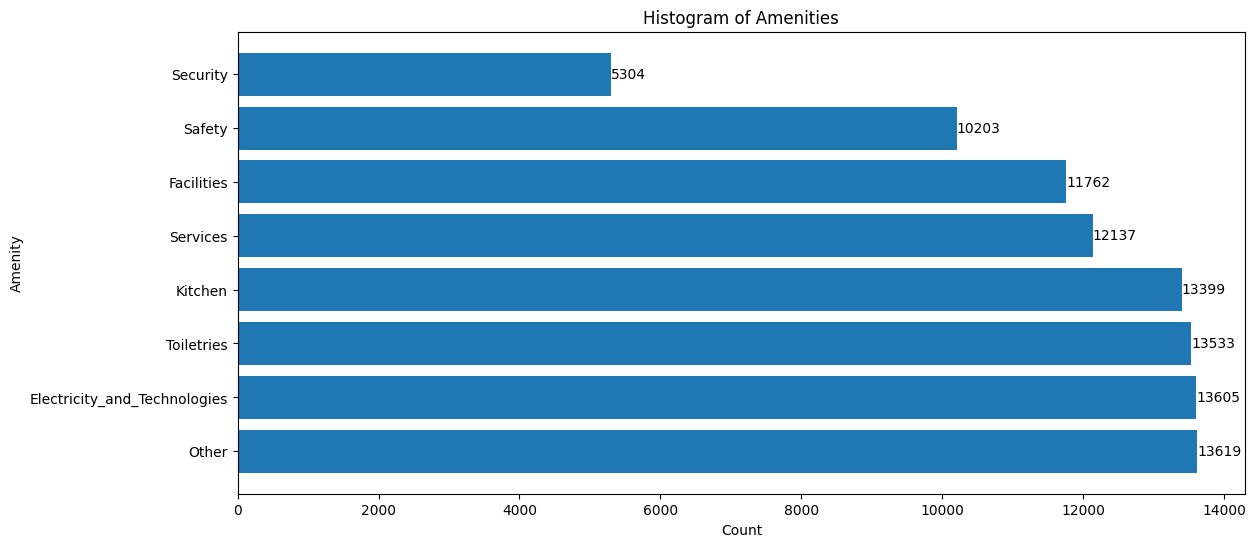

In [298]:
# 1.11 Group Amenities

# Our dictionary of categories
categories = {
    'Kitchen':  {'Stove', 'Steel', 'Stainless', 'Oven', 'Refrigerator', 'Kitchen', 'Induction', 'Olive', 'Coffee', 'Maker', 'Rice', 'Bbq', 'Coffee maker',
                'Dishes and silverware', 'Cooking basics'
                },
    'Electricity_and_Technologies': { 'TV', 'Cable TV', 'Ethernet', 'System', 'Fast', 'Pitsos', 'Bluetooth', 'Morris', 'CD', 'DVD', 'Game',
                                        'Internet', 'Chromecast', 'Aux', 'Apple', 'Connection', 'Samsung', 'Bosch', 'Microwave',
                                        'Hdtv', 'Siemens', 'Netflix', 'Amazon', 'Video', 'Wifi', 'Prime', 'Dishwasher', 'LG',
                                        'Mbps', 'Sound', 'Cable', 'Zanussi', 'Disney+', 'Electric', 'Ethernet connection', 'Dryer', 'Washer',
                                        'Air conditioning', 'Buzzer/wireless intercom'
                                    },
    'Facilities':   {'Parking', 'Garage', 'Building', 'Premises', 'Elevator', 'Bedroom', 'Bedrooms', 'Bathroom', 'Bathrooms', 'Private', 'Public', 'Balcony',
                   'Chair', 'Free street parking', 'Paid parking on premises'
                    },
    'Security': {'Lock', 'Alarm', 'Fire', 'Kit', 'Security', 'Cameras', 'Emergency', 'Escape', 'Safe', 'Pets', 'Allowed', 'Safety card',
                 'Lock on bedroom door'
                },
    'Safety': {'Carbon monoxide detector', 'Smoke detector', 'First aid kit', 'Fire extinguisher'},
    'Services': {'Service', 'Heating', 'Hot', 'Water', 'Linens', 'Breakfast', 'Dry', 'Cleaning', 'Laundry', 'Pickup', 'Rental', 'Check-in', 'Self', 'Book', 'Books'},
    'Toiletries':   {'Soap', 'Body', 'Hair', 'Shampoo', 'Conditioner', 'Closet', 'Miele', 'Papoutsanis', 'Korres', 'Pantene', 'Shower', 'Marseillais', 'Le petite',
                   'Hair dryer', 'Bathtub', 'Hot water'
                    }
}

# Create a reverse dictionary to reverse what we want to replace "categories <-> values"
words_to_replace = {word: category for category, words in categories.items() for word in words}

def replace_with_general_word(amenities):
    amenities_list = amenities.strip('{}').split(',')
    new_amenities_list = []
    found_categories = set()
    for amenity in amenities_list:
        amenity_stripped = amenity.strip('""')
        if amenity_stripped in words_to_replace:
            found_categories.add(words_to_replace[amenity_stripped])
        else:
            # new_amenities_list.append(amenity)
            found_categories.add('Other')

    new_amenities_list.extend(f'"{category}"' for category in found_categories)
    return '{' + ','.join(new_amenities_list) + '}'

# Apply our function from above to create a new column
df_train_2019_copy['grouped_amenities'] = df_train_2019_copy['amenities'].apply(replace_with_general_word)

flat_amenities = df_train_2019_copy['grouped_amenities'].str.strip('{}').str.split(',').explode()

# Remove quotes from amenities
flat_amenities = flat_amenities.str.strip('""')

amenity_counts = flat_amenities.value_counts()

plt.figure(figsize=(13, 6))
bars = plt.barh(amenity_counts.index, amenity_counts.values)

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, str(int(bar.get_width())), va='center', ha='left')

plt.title('Histogram of Amenities')
plt.xlabel('Count')
plt.ylabel('Amenity')
plt.show()

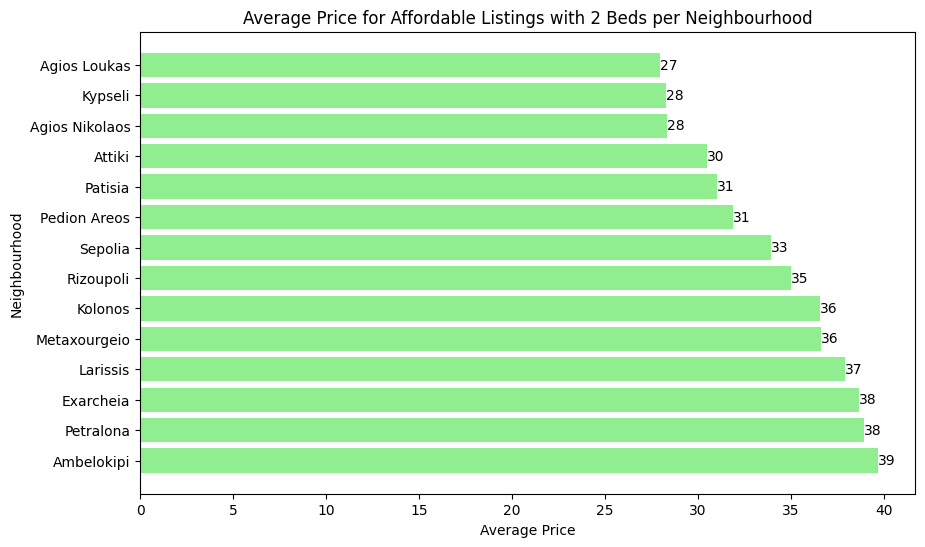

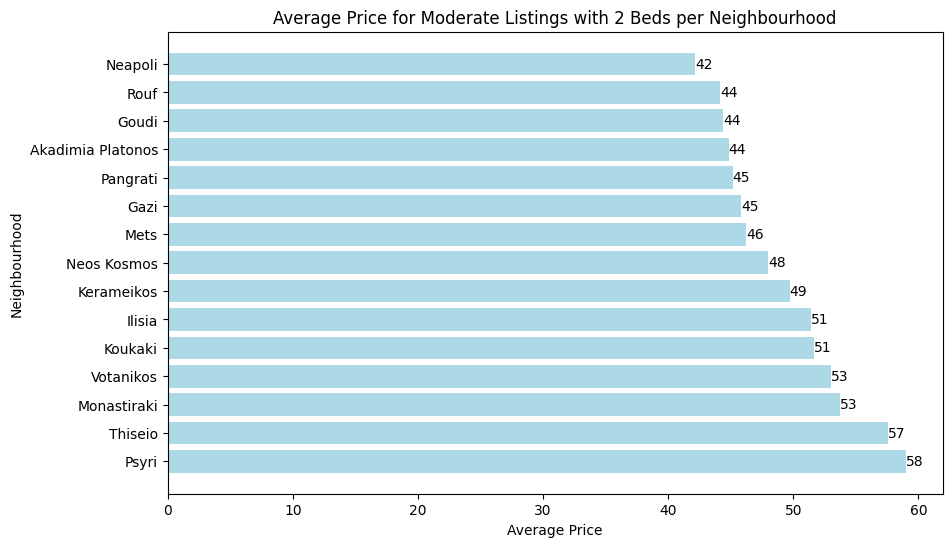

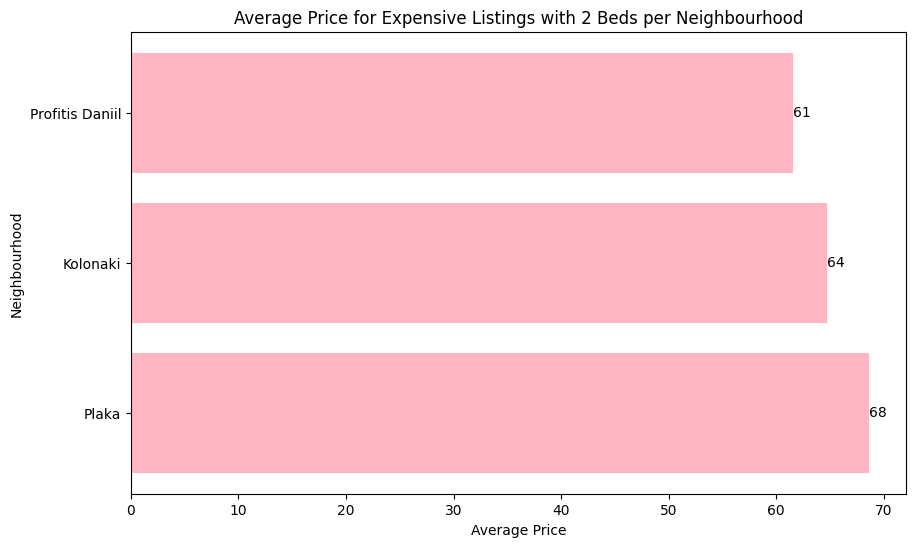

In [299]:
# 1.12 Calculate the average_price/neighbourhood for listings with exactly 2 beds
# graph for expensice listings was like the ones for affordable and moderate but changed after the price filtering

# Keep only listings with exactly 2 beds
df_2_beds = df_train_2019_copy[df_train_2019_copy['beds'] == 2]

# Group by neighbourhood and calculate the average price
average_price = df_2_beds.groupby('neighbourhood')['price_float'].mean()

sorted_average_price = average_price.sort_values(ascending=False)

# Define the price ranges -> make the 3 desired categories
bins = [0, 40, 60, sorted_average_price.max()]
labels = ['Affordable', 'Moderate', 'Expensive']

# Assign each listing to a price range with its label
sorted_average_price_df = sorted_average_price.reset_index()
sorted_average_price_df['Price Range'] = pd.cut(sorted_average_price_df['price_float'], bins=bins, labels=labels)

# Create a map for a color for each label
colors = {'Affordable': 'lightgreen', 'Moderate': 'lightblue', 'Expensive': 'lightpink'}

# Create a bar plot for each price range
for label in labels:
    data = sorted_average_price_df[sorted_average_price_df['Price Range'] == label]
    plt.figure(figsize=(10, 6))
    bars = plt.barh(data['neighbourhood'], data['price_float'], color=colors[label])
    plt.xlabel('Average Price')
    plt.ylabel('Neighbourhood')
    plt.title(f'Average Price for {label} Listings with 2 Beds per Neighbourhood')

    # Add the exact numbers on top of the bars adn adjust its positioning
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, str(int(bar.get_width())), va='center')
    plt.show()

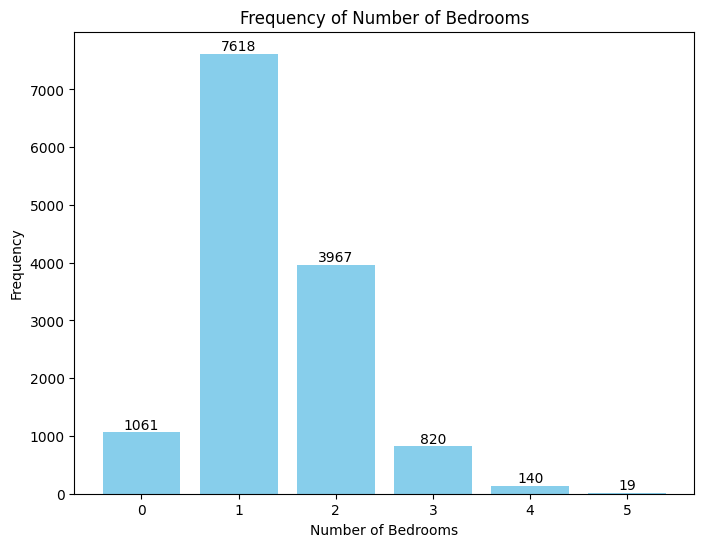

In [300]:
# 1.13a Frequency of number of bedrooms

bedroom_counts = df_train_2019_copy['bedrooms'].value_counts().sort_index(ascending=True)

plt.figure(figsize=(8, 6))
plt.bar(bedroom_counts.index, bedroom_counts.values, color='skyblue')
# Adjust x-ticks because it initially shows only even numbers as indexes
plt.xticks(range(int(bedroom_counts.index.min()), int(bedroom_counts.index.max())+1))
plt.xlabel('Number of Bedrooms')
plt.ylabel('Frequency')
plt.title('Frequency of Number of Bedrooms')
for i in range(len(bedroom_counts)):
    plt.text(bedroom_counts.index[i], bedroom_counts.values[i], str(bedroom_counts.values[i]), ha='center', va='bottom')
plt.show()

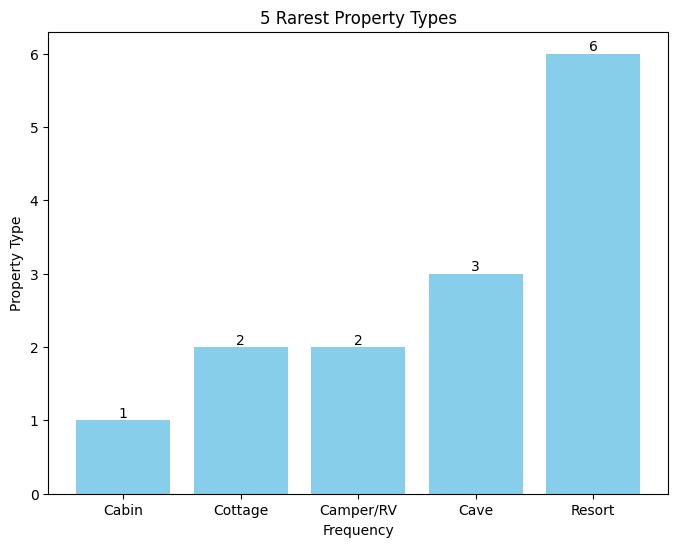

In [301]:
# 1.13b Five rarest property types

property_type_counts = df_train_2019_copy['property_type'].value_counts()

# Find the 5 rarest property types
# rarest_properties = property_type_counts.nsmallest(5) # -> gives different results
rarest_properties = property_type_counts.sort_values(ascending=True).head()

# print(rarest_properties)

plt.figure(figsize=(8, 6))
plt.bar(rarest_properties.index, rarest_properties.values, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Property Type')
plt.title('5 Rarest Property Types')

for i in range(len(rarest_properties)):
    plt.text(i, rarest_properties.values[i], str(rarest_properties.values[i]), ha='center', va='bottom')

plt.show()

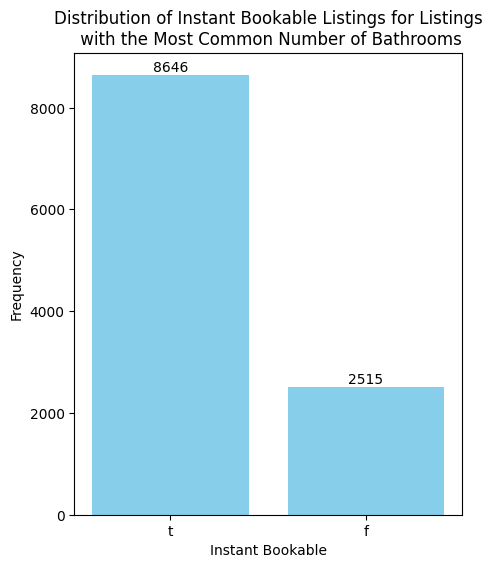

In [302]:
# 1.13c Distribution of Instant Bookable Values for Listings with the Most Common Number of Bathrooms

most_common_number_of_bathrooms = df_train_2019_copy['bathrooms'].value_counts().idxmax()

# Keep only listings with the most common number of bathrooms
common_bathroom_listings = df_train_2019_copy[df_train_2019_copy['bathrooms'] == most_common_number_of_bathrooms]

# Find the distribution of instant bookable listings
instant_bookable_distribution = common_bathroom_listings['instant_bookable'].value_counts()

# print(instant_bookable_distribution)

plt.figure(figsize=(5, 6))
plt.bar(instant_bookable_distribution.index, instant_bookable_distribution.values, color='skyblue')
plt.xlabel('Instant Bookable')
plt.ylabel('Frequency')
plt.title('Distribution of Instant Bookable Listings for Listings\n with the Most Common Number of Bathrooms')
for i in range(len(instant_bookable_distribution)):
    plt.text(i, instant_bookable_distribution.values[i], str(instant_bookable_distribution.values[i]), ha='center', va='bottom')
plt.show()

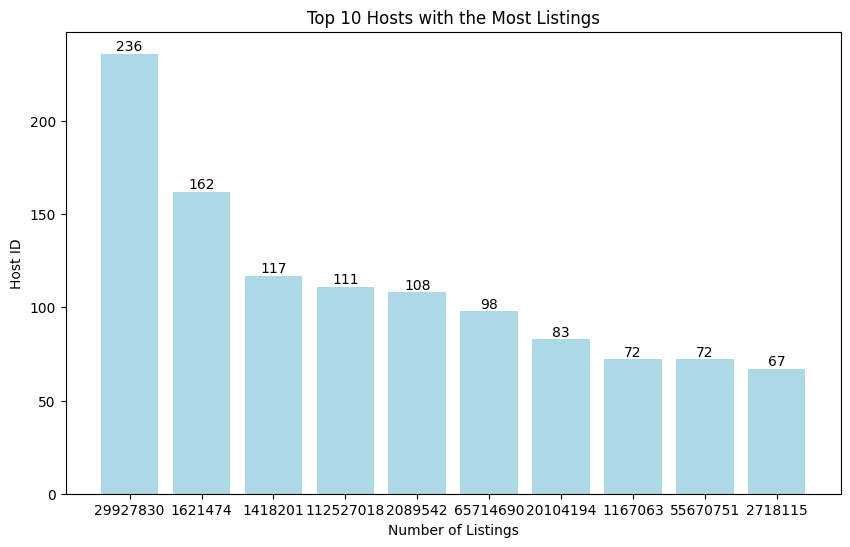

In [303]:
# 1.14 Top 10 hosts with the most listings

# First, we need to group the data by 'host_id' and count the number of listings for each host
host_listings_count = df_train_2019_copy.groupby('host_id')['id'].count()

# Then, we sort the hosts by the number of listings in descending order and take the top 10
top_10_hosts = host_listings_count.sort_values(ascending=False).head(10)
# print(top_10_hosts)

# Initialize an empty list in order to make the array tha is asked
top_10_hosts_list = []

# Loop through the top 10 hosts
for host_id in top_10_hosts.index:
    # Get the number of listings for this host
    num_listings = top_10_hosts[host_id]

    # Append a tuple with the host_id and num_listings to the list
    top_10_hosts_list.append((host_id, num_listings))

# Convert the list to an array
top_10_hosts_array = np.array(top_10_hosts_list)

# print(top_10_hosts_array)

plt.figure(figsize=(10, 6))
bars = plt.bar(top_10_hosts.index.astype(str), top_10_hosts.values, color='lightblue')
plt.xlabel('Number of Listings')
plt.ylabel('Host ID')
plt.title('Top 10 Hosts with the Most Listings')

for i in range(len(top_10_hosts)):
    plt.text(i, top_10_hosts.values[i], str(top_10_hosts.values[i]), ha='center', va='bottom')

plt.show()

In [304]:
# Load csv's and add a column 'month'
df_listings_june23 = pd.read_csv("gdrive/MyDrive/data/2023/june/listings.csv")
df_listings_june23['month'] = 'june'
df_listings_march23 = pd.read_csv("gdrive/MyDrive/data/2023/march/listings.csv")
df_listings_march23['month'] = 'march'
df_listings_sept23 = pd.read_csv("gdrive/MyDrive/data/2023/september/listings.csv")
df_listings_sept23['month'] = 'september'

df_reviews_june23 = pd.read_csv("gdrive/MyDrive/data/2023/june/reviews.csv")
df_reviews_march23 = pd.read_csv("gdrive/MyDrive/data/2023/march/reviews.csv")
df_reviews_sept23 = pd.read_csv("gdrive/MyDrive/data/2023/september/reviews.csv")

# Take all columns from official DataFrame that we're interested to
df_june23 = df_listings_june23[[
    'id', 'host_id', 'bedrooms', 'beds', 'review_scores_rating', 'number_of_reviews', 'neighbourhood_cleansed', 'name',
    'latitude', 'longitude', 'last_review', 'instant_bookable', 'host_since', 'host_response_rate',
    'host_has_profile_pic', 'first_review', 'description', 'accommodates', 'bathrooms_text', 'amenities',
    'room_type', 'property_type', 'price', 'availability_365', 'minimum_nights', 'month'
]]

df_march23 = df_listings_march23[[
    'id', 'host_id', 'bedrooms', 'beds', 'review_scores_rating', 'number_of_reviews', 'neighbourhood_cleansed', 'name',
    'latitude', 'longitude', 'last_review', 'instant_bookable', 'host_since', 'host_response_rate',
    'host_has_profile_pic', 'first_review', 'description', 'accommodates', 'bathrooms_text', 'amenities',
    'room_type', 'property_type', 'price', 'availability_365', 'minimum_nights', 'month'
]]


df_sept23 = df_listings_sept23[[
    'id', 'host_id', 'bedrooms', 'beds', 'review_scores_rating', 'number_of_reviews', 'neighbourhood_cleansed', 'name',
    'latitude', 'longitude', 'last_review', 'instant_bookable', 'host_since', 'host_response_rate',
    'host_has_profile_pic', 'first_review', 'description', 'accommodates', 'bathrooms_text', 'amenities',
    'room_type', 'property_type', 'price', 'availability_365', 'minimum_nights', 'month'
]]

# Create an one-column dataframe for comments of 2023
df_comments_june23 = df_reviews_june23['comments']
df_comments_march23 = df_reviews_march23['comments']
df_comments_sept23 = df_reviews_sept23['comments']

df_comments_23 = pd.concat([df_comments_june23, df_comments_march23, df_comments_sept23])

# Concatenate DataFrames of each month to one
df_23 = pd.concat([df_june23, df_march23, df_sept23])

In [305]:
# Clean the column 'price'
df_23['price'] = df_23['price'].str.replace('.00', '').str.replace(',', '').str.replace('$', '').astype(float)

# For each column that contains numbers, fill NaN values with mean
numerical_columns = df_23.select_dtypes(include='number').columns
for col in numerical_columns:
    mean = df_23[col].mean()
    df_23[col] = df_23[col].fillna(value=mean)
df_23['bedrooms'] = df_23['bedrooms'].astype(int)

# Drop all rows that have NaN values in Columns of type 'string'
df_23.dropna(inplace=True, ignore_index=True)

# Replace all extreme values from column 'minimum_nights' and 'price'
df_23.loc[df_23['minimum_nights'] > 365, 'minimum_nights'] = df_23['minimum_nights'].median()

# Track Outliers and filtered them out for price and bedrooms column
df_temp_price = df_23.copy()
df_temp_price['x-Mean'] = abs(df_temp_price['price'] - df_temp_price['price'].mean())
df_temp_price['1.96*std'] = 1.96*df_temp_price['price'].std()
df_23['Outlier'] = abs(df_temp_price['price'] - df_temp_price['price'].mean()) > 1.96*df_temp_price['price'].std()
df_23.loc[df_23['Outlier'] == True, 'price'] = df_temp_price['1.96*std']

df_23 = df_23[df_23['Outlier'] == False].copy()
df_23.drop(columns=['Outlier'], inplace=True) # Remove 'Outlier' column

# Export dataframe to .csv file
# df_23.to_csv('train_2023.csv', index=False)


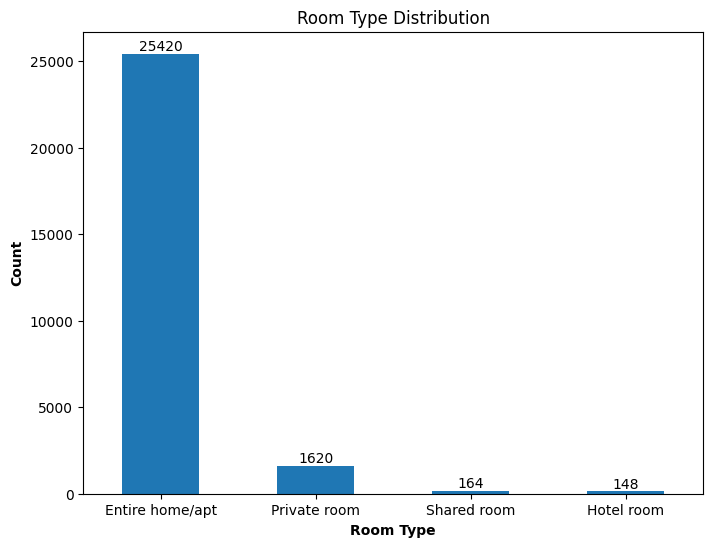

In [306]:
##### 1.1 #####
room_type_freqs = df_23['room_type'].copy().value_counts()

# print(df_23['room_type'].value_counts().idxmax()) ----> most commbon room type

plot_1_1 = room_type_freqs.plot(kind='bar', x='room_type', y='count', color='tab:blue', figsize=(8, 6))
plot_1_1.set_xlabel('Room Type', fontweight='bold')
plot_1_1.set_ylabel('Count', fontweight='bold')
plot_1_1.set_title('Room Type Distribution')
plot_1_1.tick_params(axis='x', rotation=0)
plot_1_1.bar_label(plot_1_1.containers[0], fmt='%d')
plt.show()


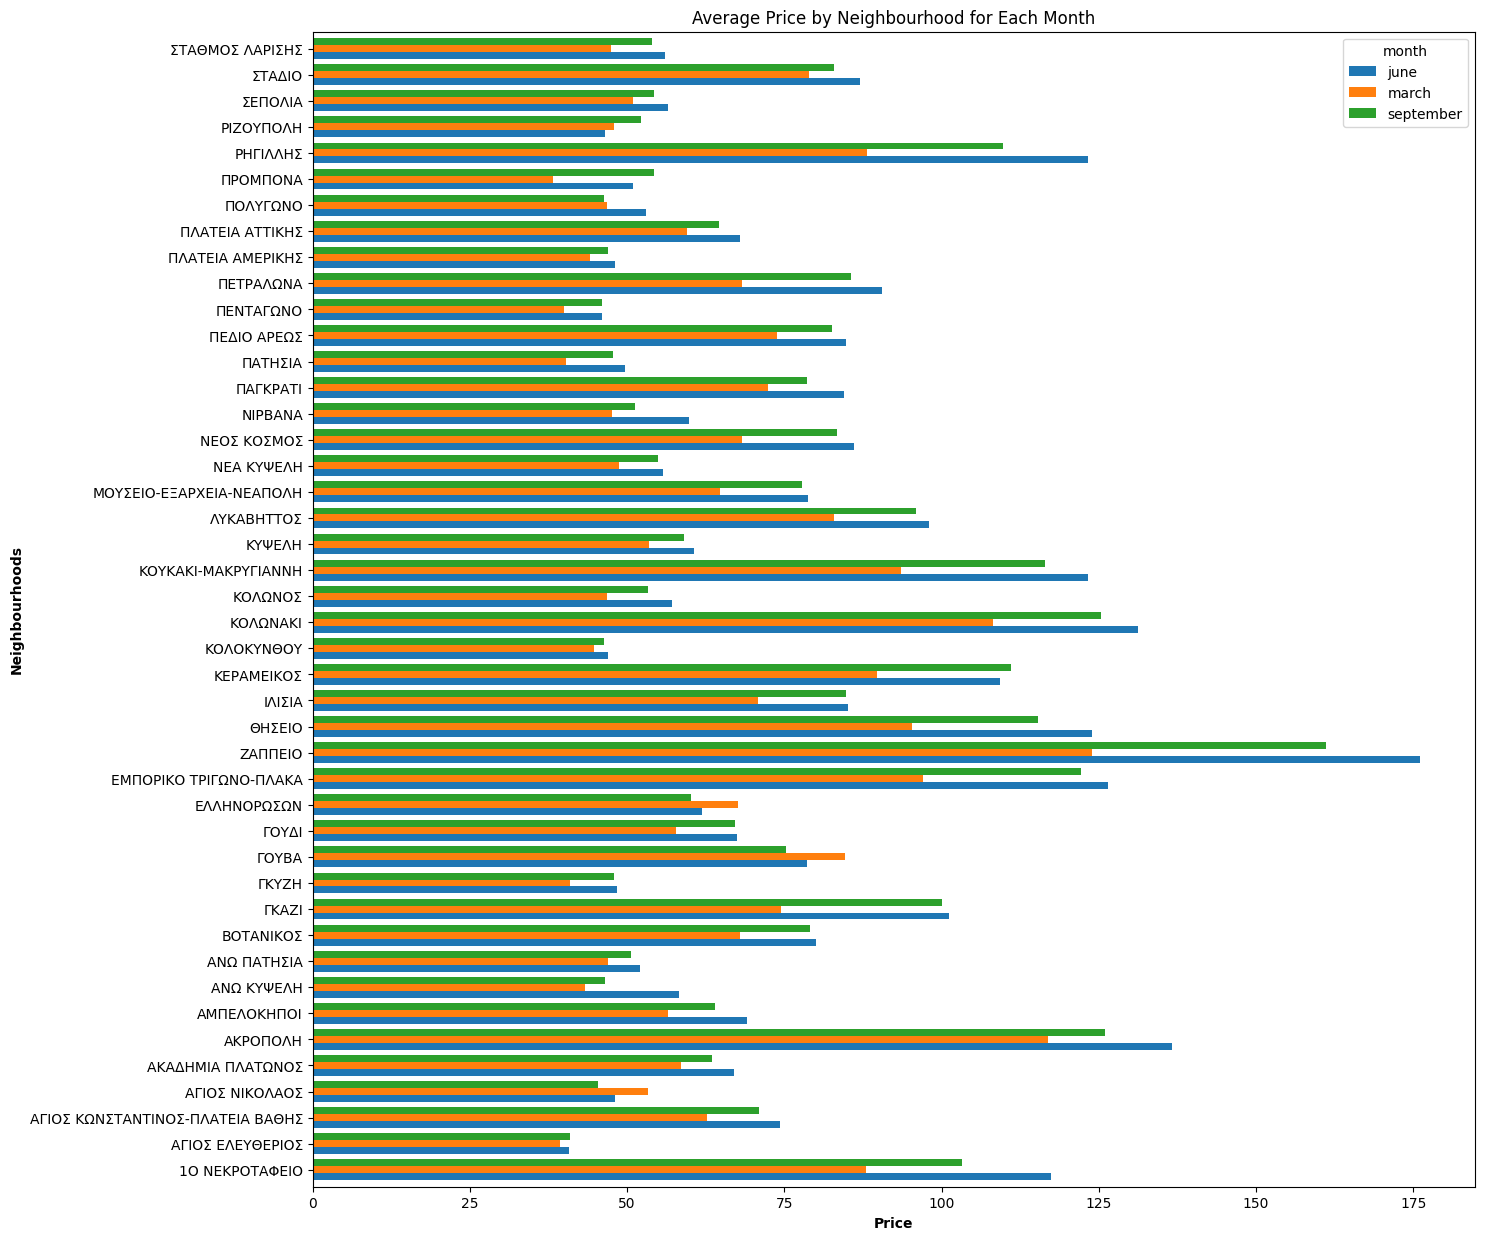

In [307]:
##### 1.2 #####
price_month_df = df_23[['neighbourhood_cleansed', 'price', 'month']].copy()
grouped_by_neighb_month = price_month_df.groupby(['neighbourhood_cleansed', 'month'])['price'].mean().reset_index()
temp_df = grouped_by_neighb_month.groupby(['month', 'neighbourhood_cleansed']).mean().reset_index()

# Add month as column
avg_price_per_month_df = temp_df.pivot(index='neighbourhood_cleansed', columns='month', values='price')

plot_1_2 = avg_price_per_month_df.plot(kind='barh', figsize=(15,15), width=0.8)
plot_1_2.set_xlabel('Price', fontweight='bold')
plot_1_2.set_ylabel('Neighbourhoods', fontweight='bold')
plot_1_2.set_title('Average Price by Neighbourhood for Each Month')
plt.show()

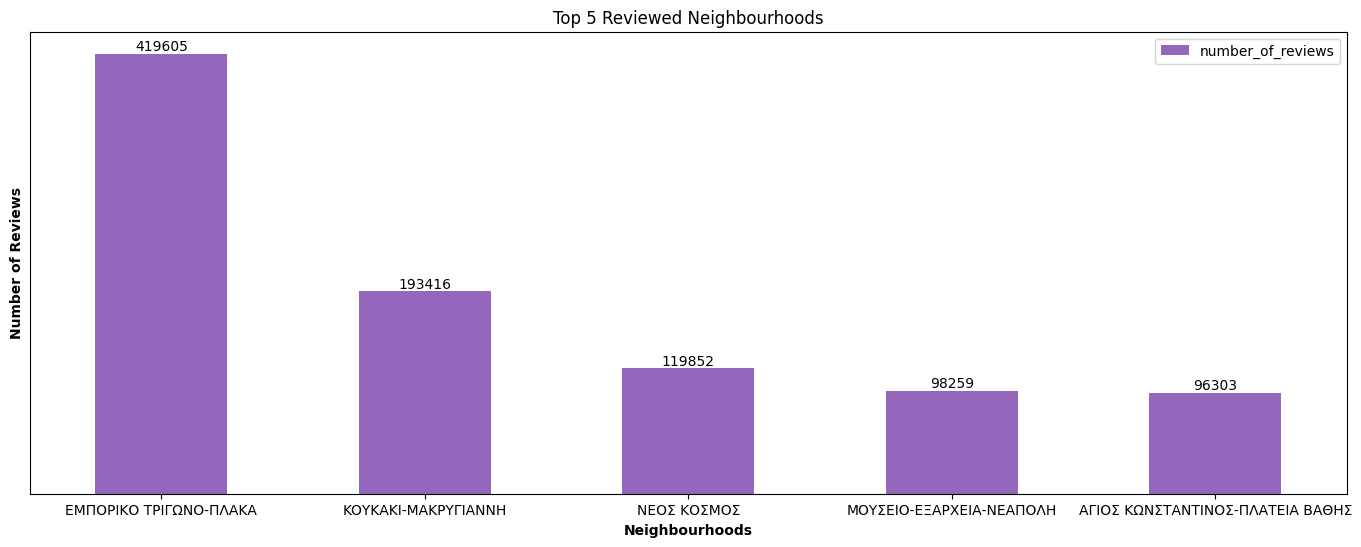

In [308]:
##### 1.3 #####
neighbourhoods_reviews_df = df_23[['neighbourhood_cleansed', 'number_of_reviews']].copy()

# Group the dataframe by neighbourhoods and sum the number_of_reviews
grouped = neighbourhoods_reviews_df.groupby('neighbourhood_cleansed').sum()

# Sort this dataframe and keep top five most reviewd
tmp_df = grouped.sort_values(by=['number_of_reviews'], ascending=False).head(5)

# Make it again a dataframe
top5_reviewed = tmp_df.reset_index()

plot_1_3 = top5_reviewed.plot(kind='bar', x='neighbourhood_cleansed', y='number_of_reviews', color='tab:purple', figsize=(17, 6))
plot_1_3.set_xlabel('Neighbourhoods', fontweight='bold')
plot_1_3.set_ylabel('Number of Reviews', fontweight='bold')
plot_1_3.set_title('Top 5 Reviewed Neighbourhoods')
plot_1_3.tick_params(axis='x', rotation=0)
plot_1_3.set_yticks([])
plot_1_3.set_yticklabels([])
plot_1_3.bar_label(plot_1_3.containers[0], fmt='%d')
plt.show()

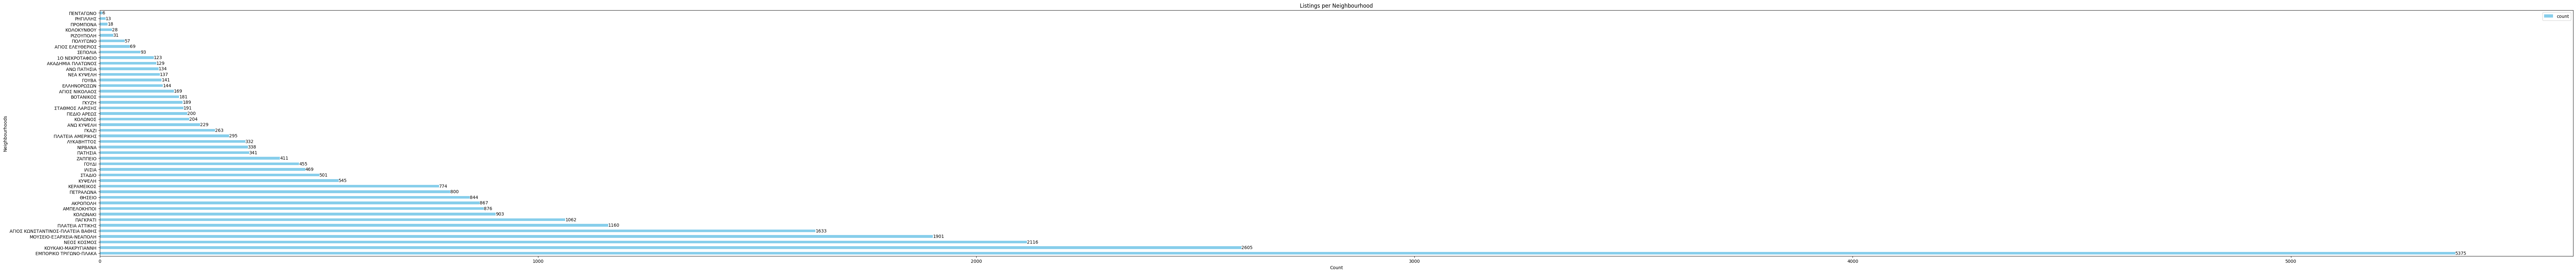

In [309]:
##### 1.4 #####
neighbourhoods_df = df_23['neighbourhood_cleansed'].value_counts().reset_index().copy()

plot_1_4 = neighbourhoods_df.plot(kind='barh', x='neighbourhood_cleansed', y='count', color='skyblue', figsize=(100, 10))
plot_1_4.set_xlabel('Count')
plot_1_4.set_ylabel('Neighbourhoods')
plot_1_4.set_title('Listings per Neighbourhood')
plot_1_4.bar_label(plot_1_4.containers[0], fmt='%d')
plt.show()

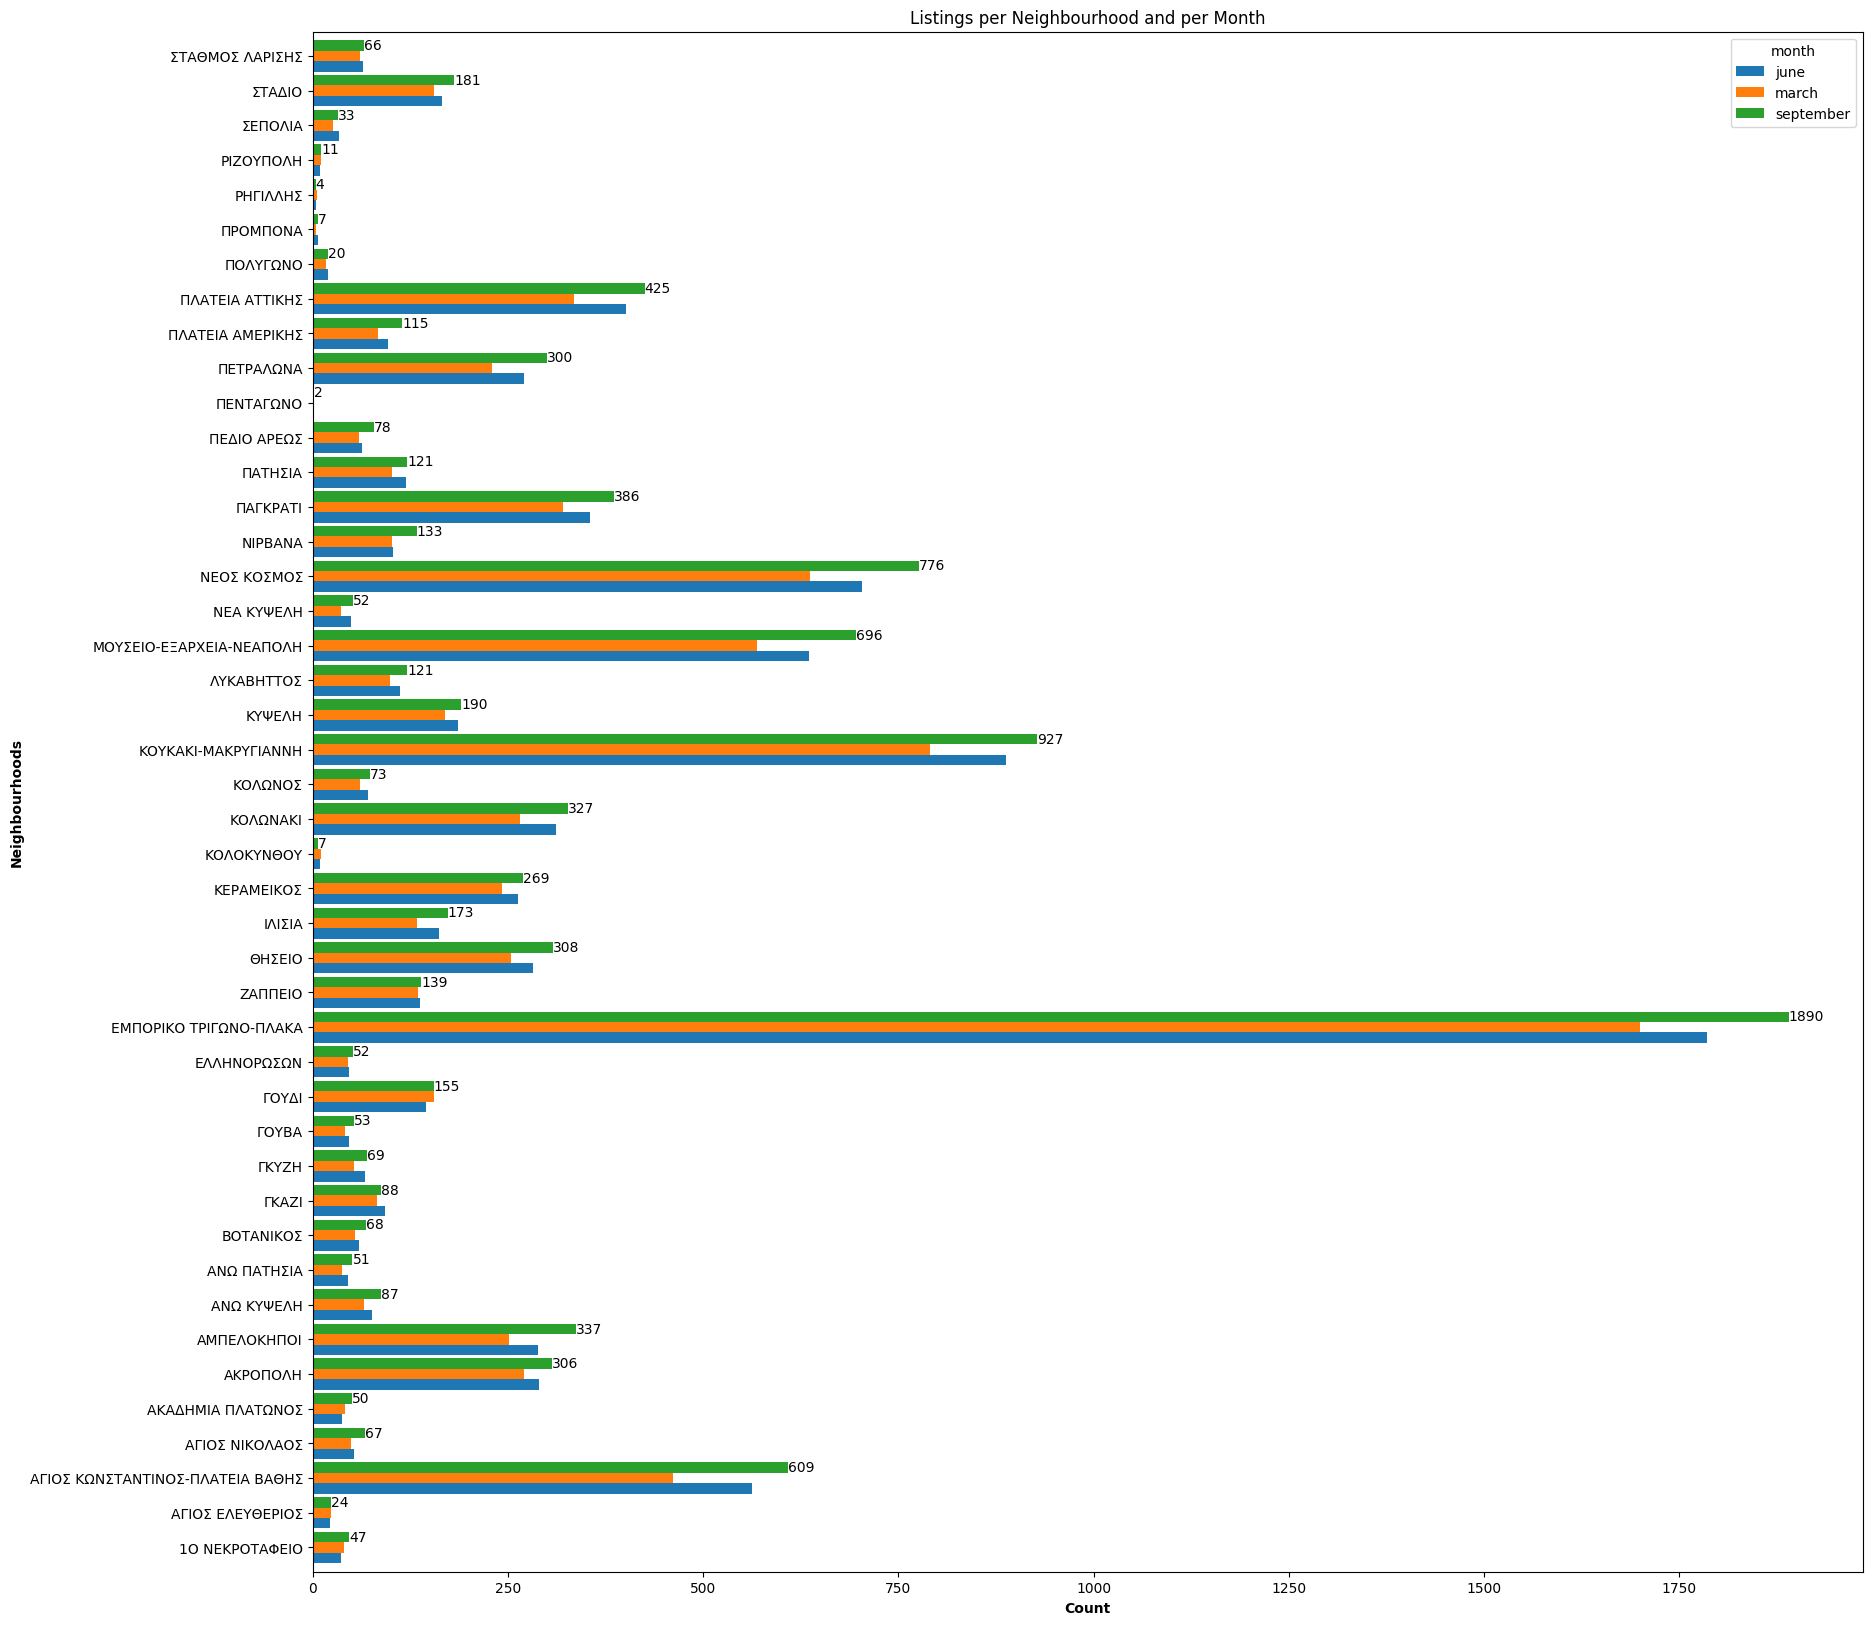

In [310]:
##### 1.5 #####
# Entries per neighbourhood
# print(neighbourhoods_df)
neighbourhoods_per_month = df_23[['neighbourhood_cleansed', 'month']].copy().groupby('month')['neighbourhood_cleansed'].value_counts().reset_index()

listings_per_neighbourhood_per_month = neighbourhoods_per_month.pivot(index='neighbourhood_cleansed', columns='month', values='count')

plot_1_5 = listings_per_neighbourhood_per_month.plot(kind='barh', figsize=(20,20), width=0.9)
plot_1_5.set_xlabel('Count', fontweight='bold')
plot_1_5.set_ylabel('Neighbourhoods', fontweight='bold')
plot_1_5.set_title('Listings per Neighbourhood and per Month')
plot_1_5.bar_label(plot_1_5.containers[2], fmt='%d')
plt.show()

array([[<Axes: title={'center': 'count'}>]], dtype=object)

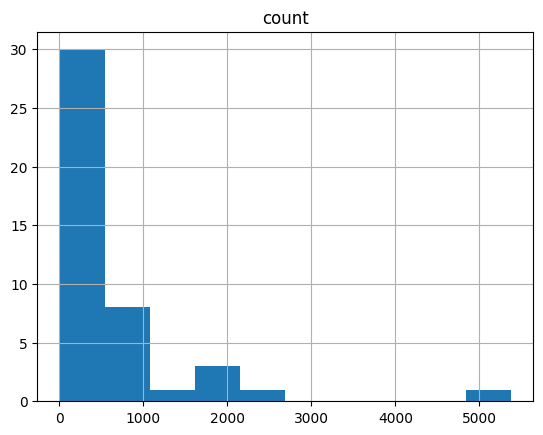

In [311]:
##### 1.6 #####
neighbourhoods_df = df_23['neighbourhood_cleansed'].copy().value_counts().reset_index()

neighbourhoods_df.hist(column='count')

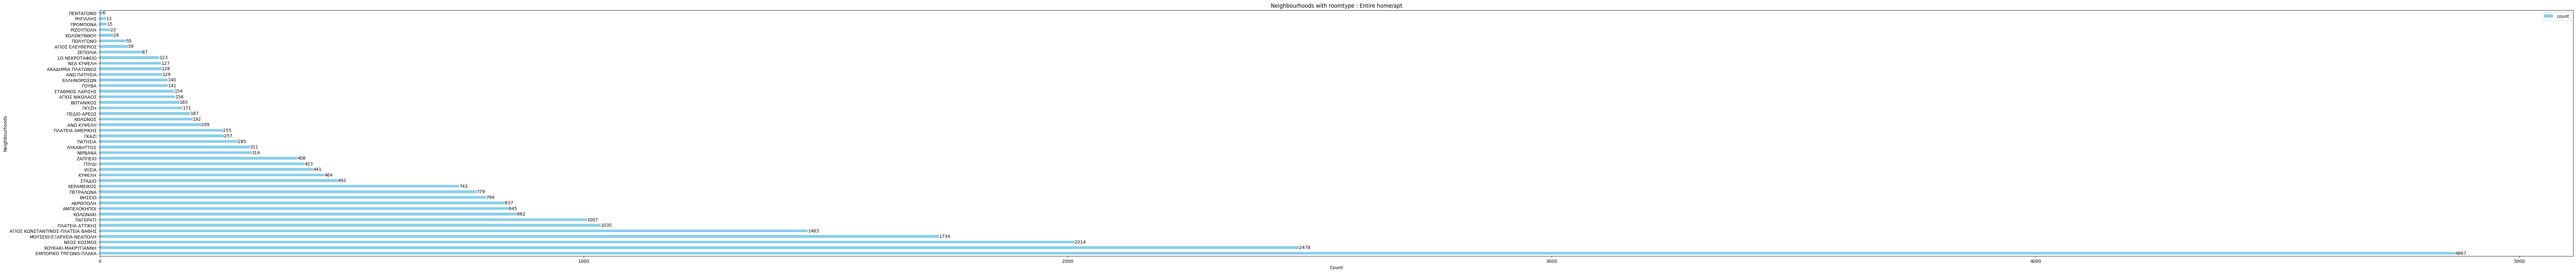

In [312]:
##### 1.7 #####
neighbourhoods_roomtype_df = df_23[['neighbourhood_cleansed', 'room_type']].copy()

# Group by neighbourhood and value for each neighbourhood which roomt type has
grouped_and_evaluated = neighbourhoods_roomtype_df.groupby('neighbourhood_cleansed').value_counts()
# Reset indexing and drop duplicates for each neighbourhood while keeping the first roomtype
top_roomtype_df = grouped_and_evaluated.reset_index().drop_duplicates(subset="neighbourhood_cleansed")


plot_1_7 = top_roomtype_df.sort_values(by='count', ascending=False).plot(kind='barh', x='neighbourhood_cleansed', y='count', color='skyblue', figsize=(100, 10))
plot_1_7.set_xlabel('Count')
plot_1_7.set_ylabel('Neighbourhoods')
plot_1_7.set_title('Neighbourhoods with roomtype : Entire home/apt')
plot_1_7.bar_label(plot_1_7.containers[0], fmt='%d')
plt.show()

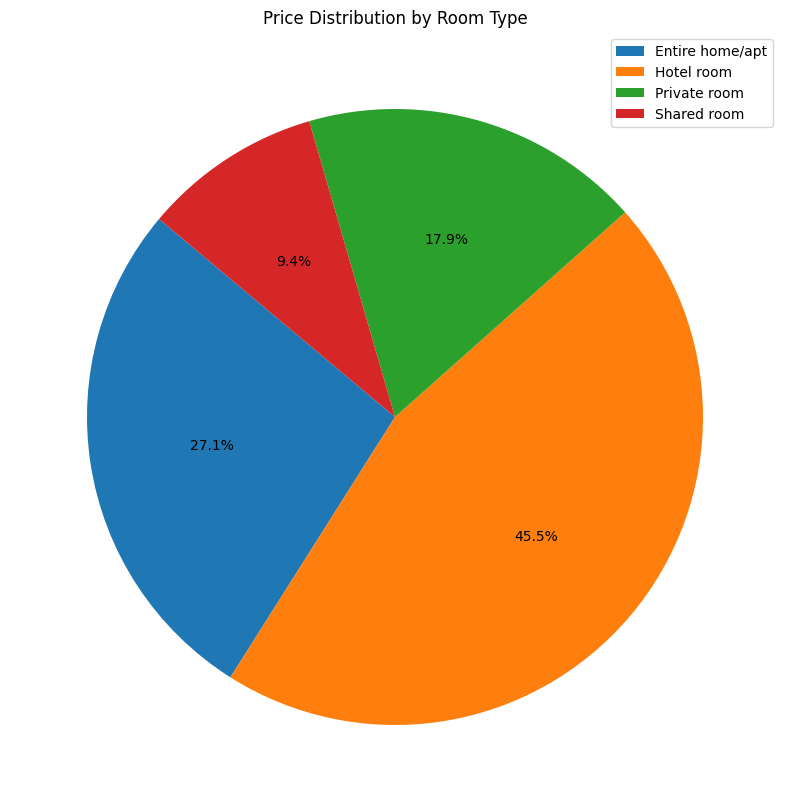

In [313]:
##### 1.8 #####
roomtype_prices_df = df_23[['room_type', 'price']].copy()

total_price_roomtypes = roomtype_prices_df.groupby('room_type').mean().reset_index()

plot_1_8 = total_price_roomtypes.plot(kind='pie', y='price', labels=None, autopct='%.1f%%', startangle=140, figsize=(10, 10))
plot_1_8.set_ylabel('')  # Remove y-axis label
plot_1_8.set_title('Price Distribution by Room Type')
plot_1_8.legend(total_price_roomtypes['room_type'], loc='upper right')  # Add legend with room types
plt.show()

In [314]:
##### 1.9 #####
property_locations = df_23[['latitude', 'longitude', 'room_type']].copy()
# Take a sample of rows in order to be the map usable
sample_of_locations = property_locations.sample(n=500)

# Create a Map located by means of latitude and longitude
properties_map = folium.Map(location=[sample_of_locations.latitude.mean(), sample_of_locations.longitude.mean()],
                            zoom_start=14, control_scale=True)

# Add pop-up info
for index, location_info in sample_of_locations.iterrows():
    folium.Marker([location_info["latitude"], location_info["longitude"]], popup=location_info["room_type"], ).add_to(properties_map)

display(properties_map)

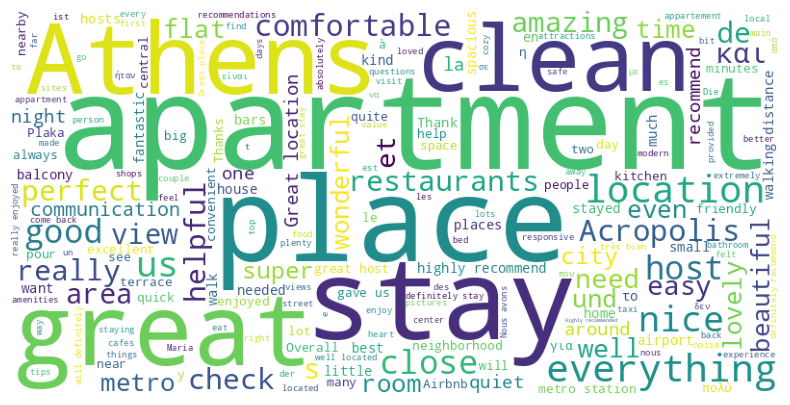

In [315]:
##### 1.10a ######

# Word Cloud for comments of 2023
df_sample_comments_23 = df_comments_23.copy().sample(1000)
comments_text_23 = df_sample_comments_23.str.cat()
comments_text_23 = comments_text_23.replace("<br/>", "")

wcloud_comments_23 = wc.WordCloud(width=800, height=400, background_color='white', normalize_plurals=False).generate(comments_text_23)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wcloud_comments_23)
plt.axis('off')
plt.show()

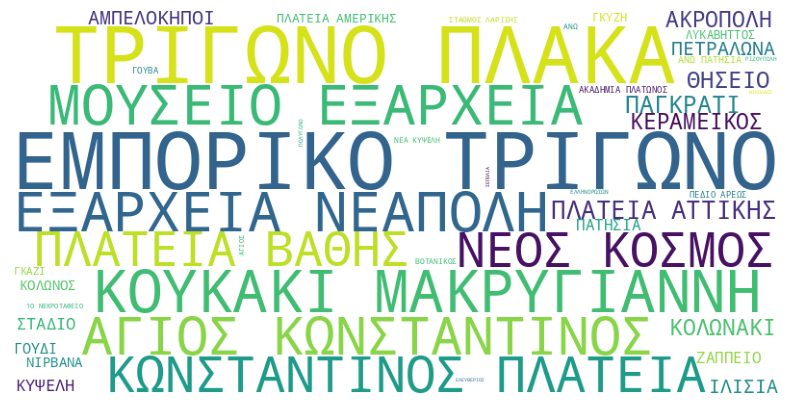

In [316]:
##### 1.10b #####
df_neighbourhoods_23 = df_23['neighbourhood_cleansed'].copy().str.replace(' ', '-')
df_neighbourhoods_sample_23 = df_neighbourhoods_23.sample(1000)
neighbourhoods_text_23 = df_neighbourhoods_sample_23.str.cat(sep=' ')

wcloud_neighbourhood_23 = wc.WordCloud(width=800, height=400, background_color='white', normalize_plurals=False).generate(neighbourhoods_text_23)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wcloud_neighbourhood_23)
plt.axis('off')
plt.show()


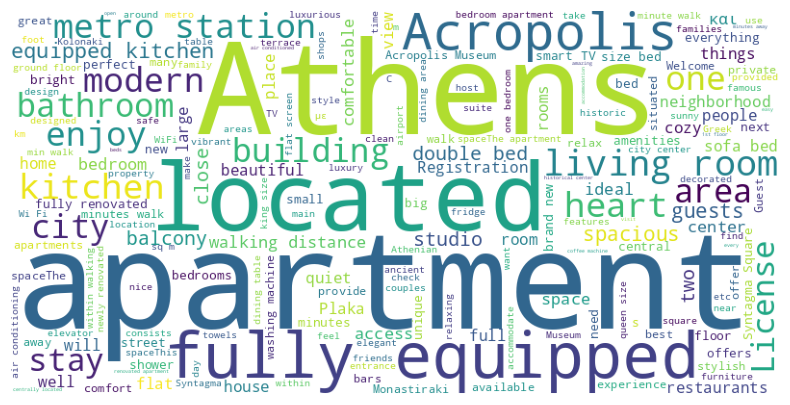

In [317]:
##### 1.10c #####
# Keep descriptions by replacing html code
df_descriptions_23 = df_23['description'].copy().str.replace("<br />", '').str.replace("<b>", '').str.replace("</b>", '').str.replace(',', ' ').str.replace('.', ' ')
df_descriptions_sample_23 = df_descriptions_23.sample(1000)
# descriptions_text_23 = df_descriptions_sample_23.str.cat(sep=' ')
descriptions_text_23 = " ".join(description for description in df_descriptions_sample_23)

wcloud_description_23 = wc.WordCloud(width=800, height=400, background_color='white', normalize_plurals=False).generate(descriptions_text_23)

plt.figure(figsize=(10, 5))
plt.imshow(wcloud_description_23)
plt.axis('off')
plt.show()

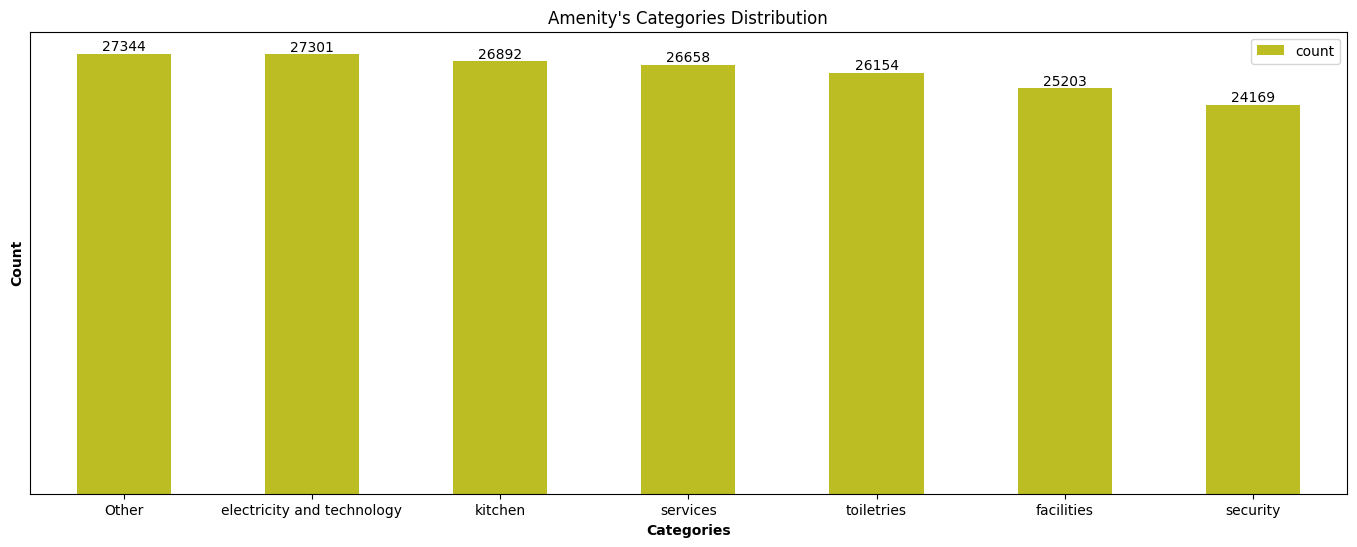

In [318]:
##### 1.11 #####
# Convert amenities' column from sets of strings to lists of strings
df_amenities_23 = df_23['amenities'].copy().str.replace(", ", ',').str.replace('"', '').str.replace('[', '').str.replace(']', '').str.split(',')
# Explode each list of amenities in order to keep unique amenities
df_unique_amenities_23 = df_amenities_23.explode().unique()

# Create a counter that counts unique words in order to see the most common amenities
amenity_frequency_counter = Counter()

for string in list(df_unique_amenities_23):
    words = string.split()
    amenity_frequency_counter.update(words)

# Extract most common and print to see it
most_common = dict(amenity_frequency_counter.most_common())
# print(most_common)

# Create a dictionary manually of common keywords for each category of amenities
categories = {'kitchen' : ['stove', 'steel', 'stainless', 'oven', 'refrigerator', 'kitchen', 'induction', 'olive', 'coffee', 'maker', 'rice', 'bbq'],
              'facilities' : ['parking', 'garage', 'building', 'premises', 'elevator', 'bedroom', 'bedrooms', 'bathroom', 'bathrooms', 'private', 'public', 'balcony', 'chair'],
              'electricity and technology' : ['dishwasher', 'microwave', 'ethernet', 'connection','hdtv', 'mbps', 'electric', 'wifi', 'fast', 'system', 'sound', 'tv', 'bluetooth', 'cable',
                                              'aux', 'netflix', 'bosch', 'chromecast', 'amazon', 'prime', 'video', 'disney+', 'pitsos', 'apple',
                                              'siemens', 'cd', 'dvd', 'lg', 'pitsos', 'bosch', 'morris', 'samsung', 'zanussi', 'game'],
              'security' : ['lock', 'alarm', 'fire', 'kit', 'security', 'cameras', 'emergency', 'escape', 'safe', 'pets', 'allowed'],
              'services' : ['service', 'heating', 'hot', 'water', 'linens', 'breakfast', 'dry', 'cleaning', 'laundry', 'pickup', 'rental', 'check-in', 'self', 'book', 'books'],
              'toiletries' : ['soap', 'body', 'hair', 'shampoo', 'conditioner', 'closet', 'miele', 'papoutsanis', 'shampoo', 'korres', 'pantene', 'shower', 'marseillais', 'le petite']
            }

# Method to find the category of an amenity
def find_category(amenity):
    for category, keywords in categories.items():
        for word in amenity.split():
            if word.lower() in keywords:
                return category
    return 'Other'

# Method that returns a list of corresponding categories from a list of amenities
def get_categorized_amenities(amenities):
    categorized_amenities = list()
    for amenity in amenities:
        category = find_category(amenity)
        if category not in categorized_amenities:
            categorized_amenities.append(category)
            if (len(categorized_amenities) == 7):   # No need to categorize amenities after we have reached a full-category list
                break

    return categorized_amenities

# Categorize the whole column
categorized_amenities = list()
for i in range(df_amenities_23.size):
    categorized_amenities.append(get_categorized_amenities(df_amenities_23.iloc[i]))

# After that, create a dataframe and concatenate it with the official dataframe for 2023
df_categorized_amenities = pd.DataFrame({'categorized_amenities' : categorized_amenities})

df_augmented_23 = pd.concat([df_23, df_categorized_amenities], axis=1)

df_categories_freq = df_categorized_amenities.explode('categorized_amenities').value_counts().reset_index()

# Histogram to show the frequencies of amenity's category
plot_1_11 = df_categories_freq.plot(kind='bar', x='categorized_amenities', y='count', color='tab:olive', figsize=(17, 6))
plot_1_11.set_xlabel('Categories', fontweight='bold')
plot_1_11.set_ylabel('Count', fontweight='bold')
plot_1_11.set_title('Amenity\'s Categories Distribution')
plot_1_11.tick_params(axis='x', rotation=0)
plot_1_11.set_yticks([])
plot_1_11.set_yticklabels([])
plot_1_11.bar_label(plot_1_11.containers[0], fmt='%d')
plt.show()


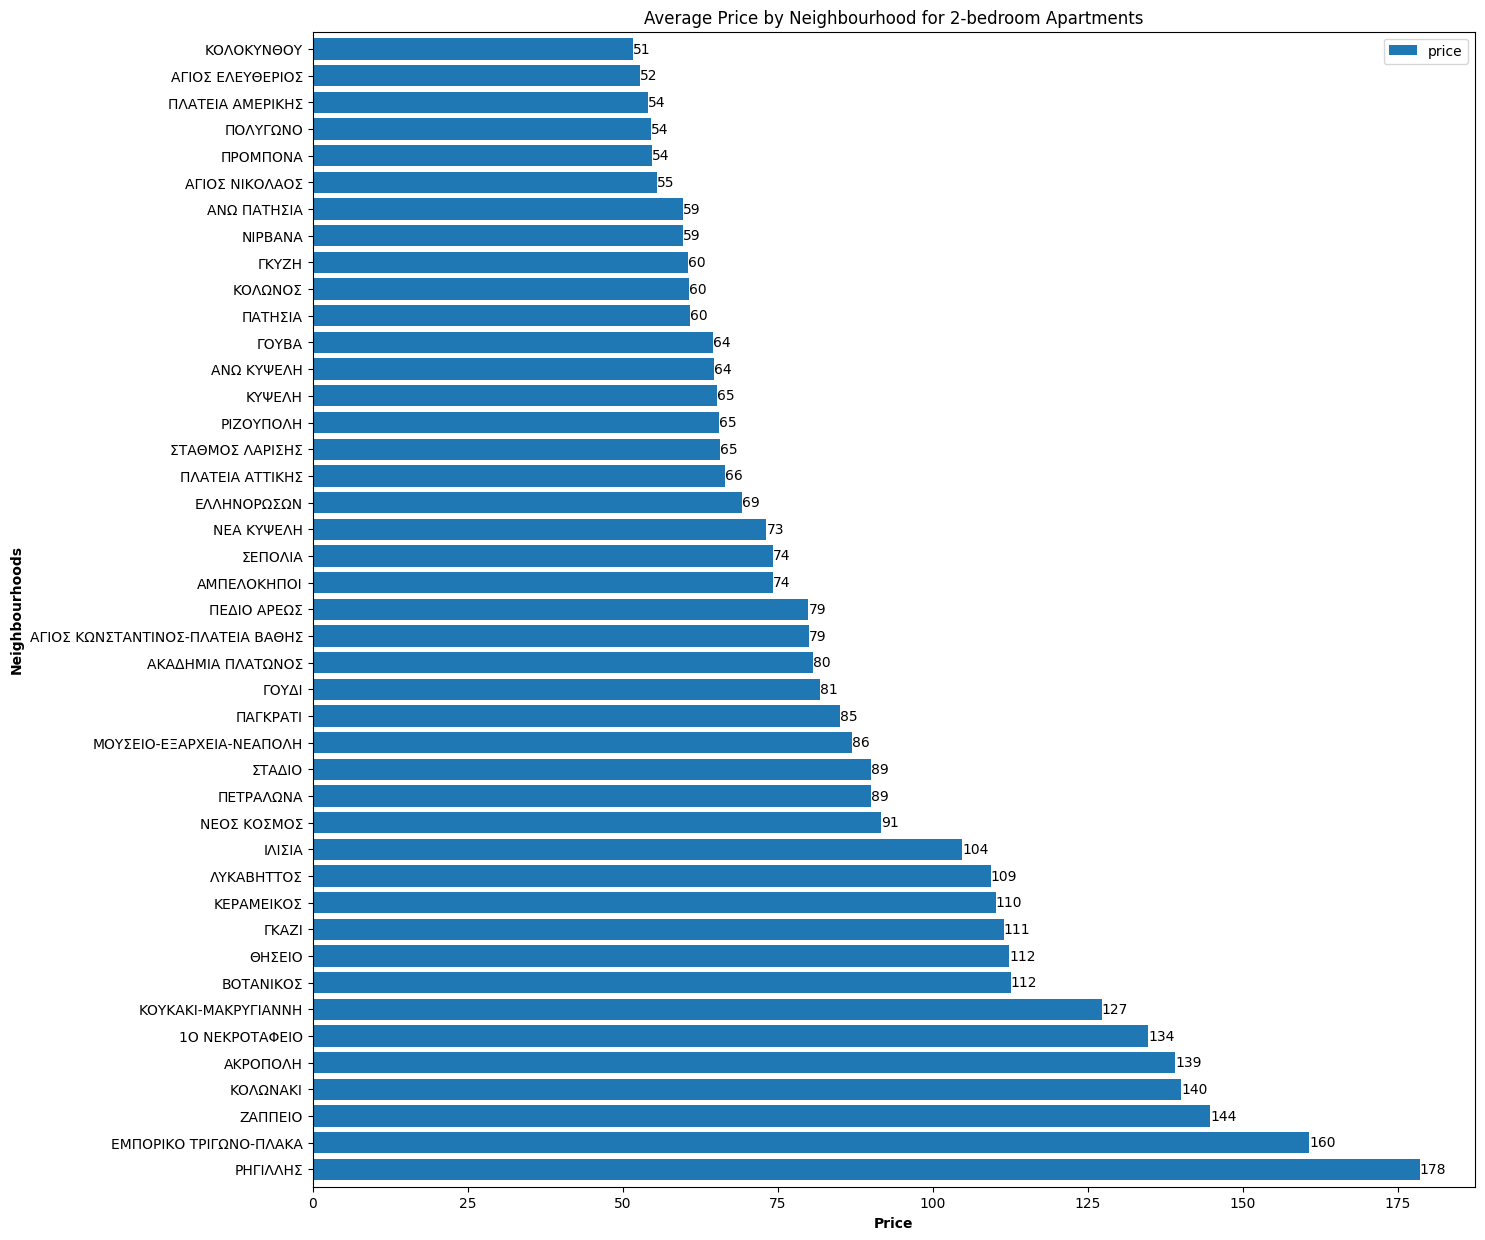

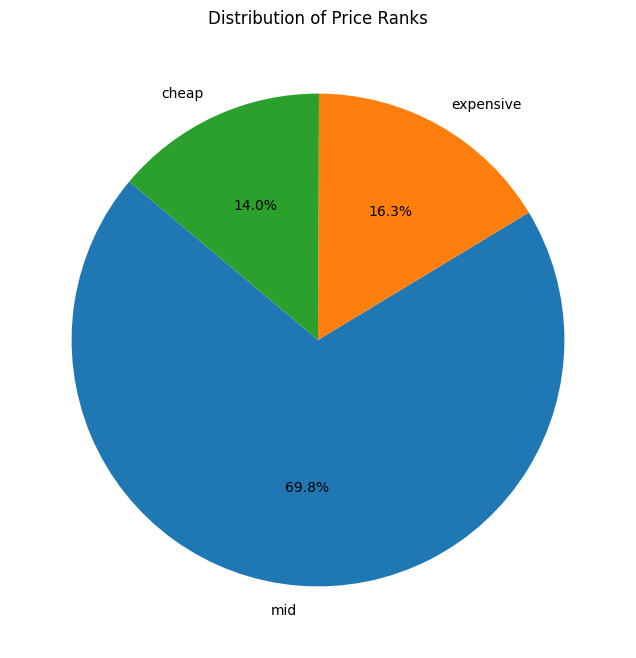

In [319]:
##### 1.12 #####
df_neighbourhoods_price_bedrooms_23 = df_23[['neighbourhood_cleansed', 'price', 'bedrooms']].copy()
df_neighbourhoods_price_two_bedrooms_23 = df_neighbourhoods_price_bedrooms_23[df_neighbourhoods_price_bedrooms_23['bedrooms'] == 2]
df_neighbourhoods_price_with_two_bedrooms_23 = df_neighbourhoods_price_two_bedrooms_23[['neighbourhood_cleansed', 'price']]

df_mean_of_neighbourhoods = df_neighbourhoods_price_with_two_bedrooms_23.groupby('neighbourhood_cleansed')['price'].mean().reset_index()

df_mean_of_neighbourhoods_sorted = df_mean_of_neighbourhoods.sort_values(by=['price'], ascending=False)

plot_1_12a = df_mean_of_neighbourhoods_sorted.plot(kind='barh', x='neighbourhood_cleansed', y='price', figsize=(15,15), width=0.8)
plot_1_12a.set_xlabel('Price', fontweight='bold')
plot_1_12a.set_ylabel('Neighbourhoods', fontweight='bold')
plot_1_12a.bar_label(plot_1_12a.containers[0], fmt='%d')
plot_1_12a.set_title('Average Price by Neighbourhood for 2-bedroom Apartments')
plt.show()

max_mean_price = df_mean_of_neighbourhoods_sorted['price'].max()
interval_sep = max_mean_price/3

price_intervals = [0, interval_sep, interval_sep * 2, max_mean_price+1]
price_labels = ['cheap', 'mid', 'expensive']

df_mean_of_neighbourhoods['price_rank'] = pd.cut(df_mean_of_neighbourhoods['price'], bins=price_intervals, labels=price_labels, right=False)


df_rank_counts = df_mean_of_neighbourhoods['price_rank'].value_counts()

# Plot pie chart for price rank distribution
plot_1_12b = df_rank_counts.plot(kind='pie', labels=df_rank_counts.index, autopct='%.1f%%', startangle=140, figsize=(8, 8))
plot_1_12b.set_ylabel('')  # Remove y-axis label
plot_1_12b.set_title('Distribution of Price Ranks')
plt.show()


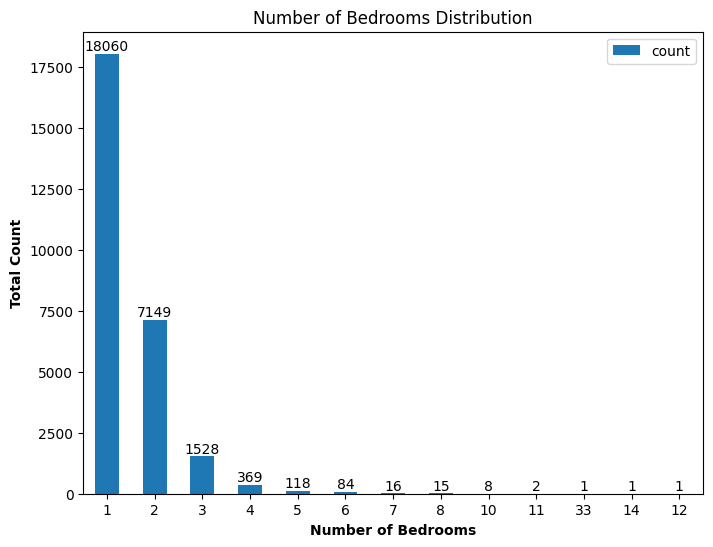

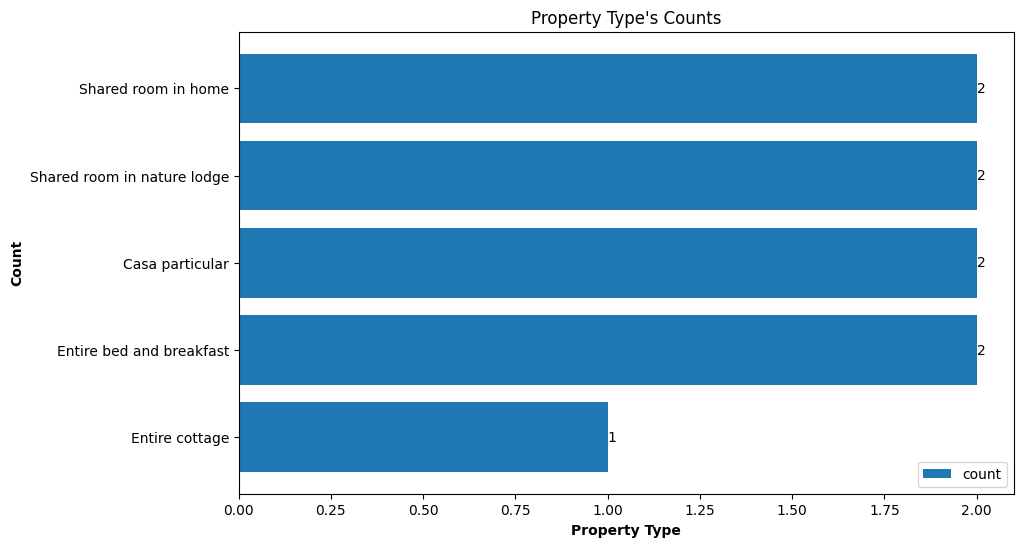

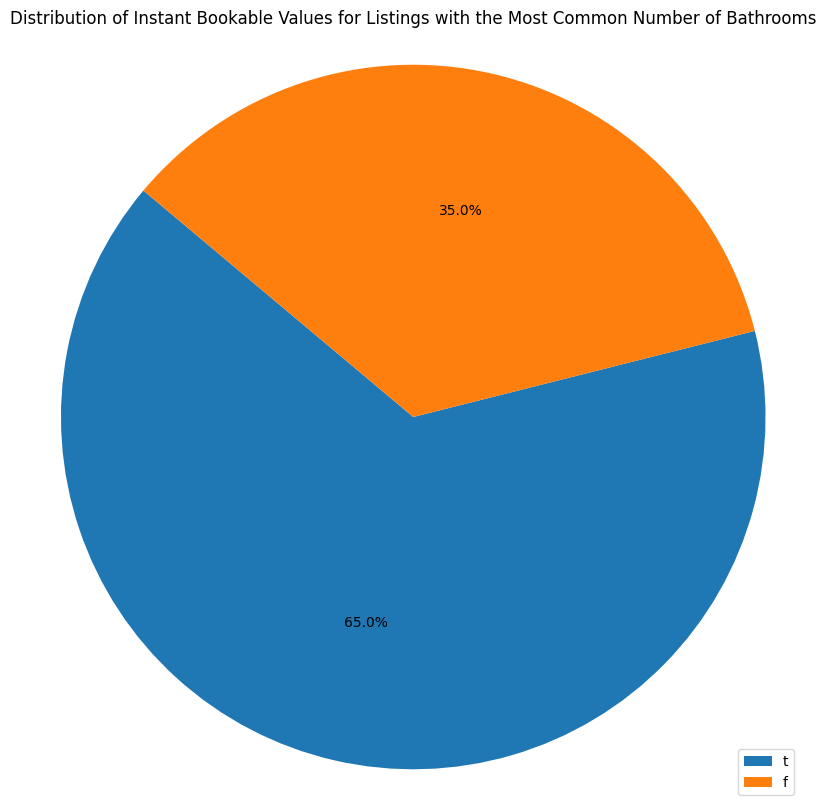

In [320]:
##### 1.13 #####
# 1. Frequency of number of bedrooms
df_bedrooms_23 = df_23['bedrooms'].copy().value_counts().reset_index()

plot_1_13a = df_bedrooms_23.plot(kind='bar', x='bedrooms', y='count', color='tab:blue', figsize=(8, 6))
plot_1_13a.set_xlabel('Number of Bedrooms', fontweight='bold')
plot_1_13a.set_ylabel('Total Count', fontweight='bold')
plot_1_13a.set_title('Number of Bedrooms Distribution')
plot_1_13a.tick_params(axis='x', rotation=0)
plot_1_13a.bar_label(plot_1_13a.containers[0], fmt='%d')
plt.show()

# 2. Five rarest property types
df_property_type = df_23['property_type'].value_counts().reset_index().sort_values(by='count', ascending=True).reset_index(drop=True).head(5)

plot_1_13b = df_property_type.plot(kind='barh', x='property_type', y='count', figsize=(10,6), width=0.8)
plot_1_13b.set_xlabel('Property Type', fontweight='bold')
plot_1_13b.set_ylabel('Count', fontweight='bold')
plot_1_13b.set_title('Property Type\'s Counts')
plot_1_13b.bar_label(plot_1_13b.containers[0], fmt='%d')
plt.show()

# 3. Distribution of Instant Bookable Values for Listings with the Most Common Number of Bathrooms
df_most_common_no_bathrooms = df_23['bathrooms_text'].value_counts().reset_index().sort_values(by='count', ascending=False).head(1)
most_common_no_bathrooms = df_most_common_no_bathrooms.iat[0,0]

df_only_most_common_no_bathrooms = df_23[df_23['bathrooms_text'] == most_common_no_bathrooms]
df_ibookable_with_most_common_no_bathrooms = df_only_most_common_no_bathrooms['instant_bookable'].value_counts().reset_index()

plot_1_13c = df_ibookable_with_most_common_no_bathrooms.plot(kind='pie', y='count', labels=None, autopct='%.1f%%', startangle=140, figsize=(10, 10))
plot_1_13c.set_ylabel('')  # Remove y-axis label
plot_1_13c.set_title('Distribution of Instant Bookable Values for Listings with the Most Common Number of Bathrooms')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plot_1_13c.legend(df_ibookable_with_most_common_no_bathrooms['instant_bookable'], loc='lower right')  # Add legend with room types
plt.show()


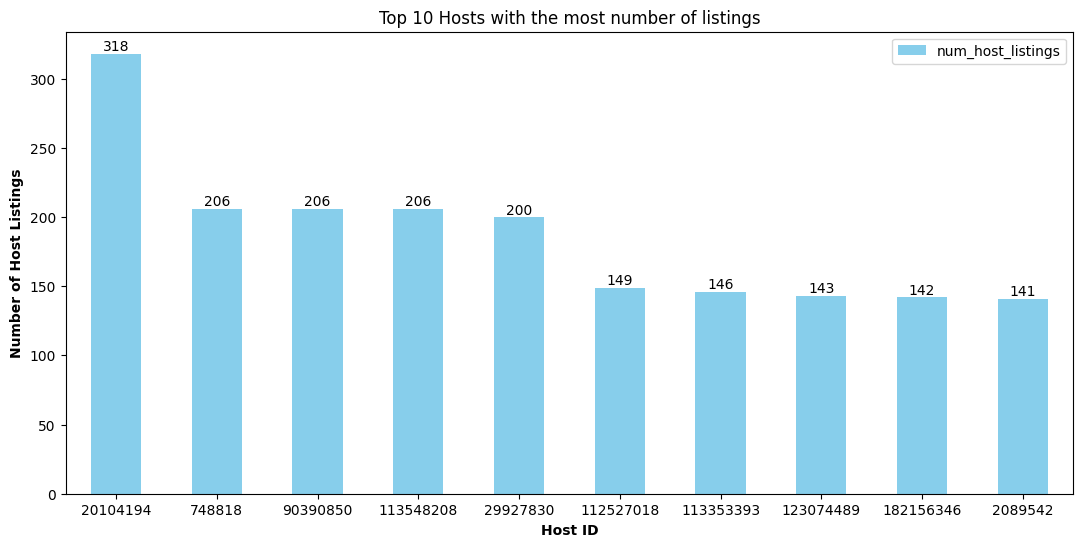

In [321]:
##### 1.14 ######
df_host_ids = df_23['host_id'].copy().value_counts().head(10).reset_index()

df_host_ids = df_host_ids.rename(columns={'count': 'num_host_listings'})

plot_1_14 = df_host_ids.plot(kind='bar', x='host_id', y='num_host_listings', color='skyblue', figsize=(13, 6))
plot_1_14.set_xlabel('Host ID', fontweight='bold')
plot_1_14.set_ylabel('Number of Host Listings', fontweight='bold')
plot_1_14.set_title('Top 10 Hosts with the most number of listings')
plot_1_14.tick_params(axis='x', rotation=0)
plot_1_14.bar_label(plot_1_14.containers[0], fmt='%d')
plt.show()

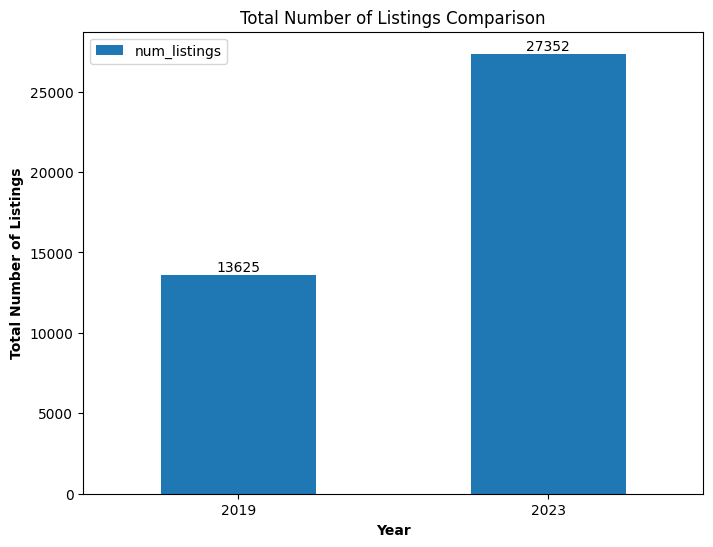

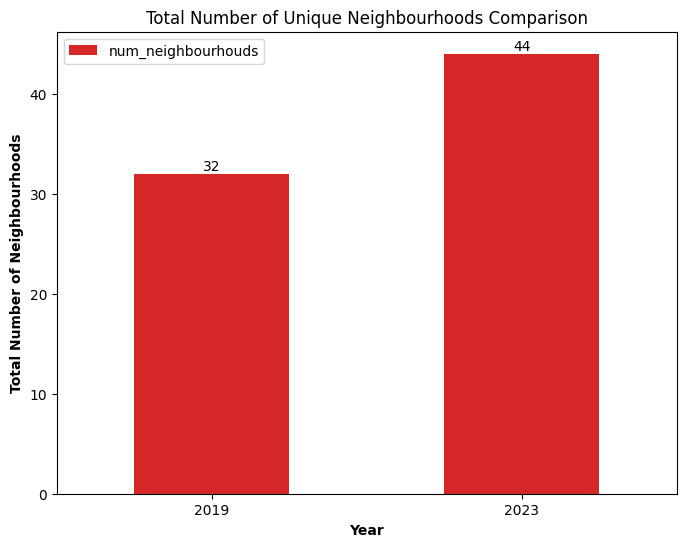

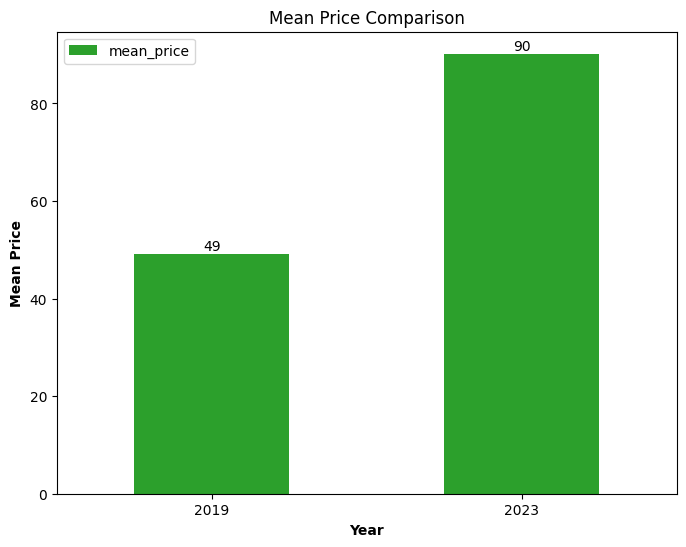

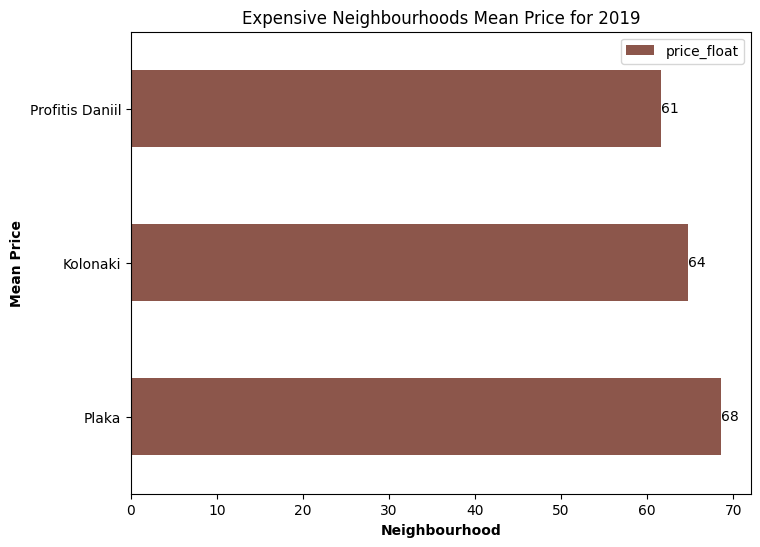

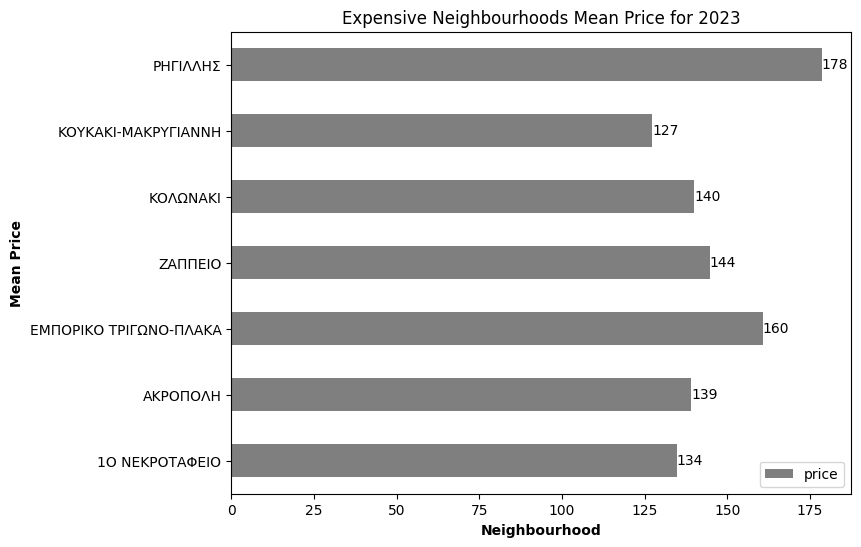

In [322]:
# Metrics for year comparison
num_listings_19 = df_train_2019.shape[0]
num_listings_23 = df_23.shape[0]

num_neighbourhoods_19 = df_train_2019['neighbourhood'].copy().unique().shape[0]
num_neighbourhoods_23 = df_23['neighbourhood_cleansed'].copy().unique().shape[0]

mean_price_19 = df_train_2019['price'].copy().str.replace('.00', '').str.replace(',', '').str.replace('$', '').astype(float).mean()
mean_price_23 = df_23['price'].copy().mean()

comparison_data = {'num_listings': [num_listings_19, num_listings_23],
            'num_neighbourhouds': [num_neighbourhoods_19, num_neighbourhoods_23],
            'mean_price': [mean_price_19, mean_price_23],
            'year' : ['2019', '2023']}

# Create a comparison dataframe from comparison_data dictionary
df_comparison = pd.DataFrame(comparison_data)

plot_1_15a = df_comparison.plot(kind='bar', x='year', y='num_listings', color='tab:blue', figsize=(8, 6))
plot_1_15a.set_xlabel('Year', fontweight='bold')
plot_1_15a.set_ylabel('Total Number of Listings', fontweight='bold')
plot_1_15a.set_title('Total Number of Listings Comparison')
plot_1_15a.tick_params(axis='x', rotation=0)
plot_1_15a.bar_label(plot_1_15a.containers[0], fmt='%d')
plt.show()

plot_1_15b = df_comparison.plot(kind='bar', x='year', y='num_neighbourhouds', color='tab:red', figsize=(8, 6))
plot_1_15b.set_xlabel('Year', fontweight='bold')
plot_1_15b.set_ylabel('Total Number of Neighbourhoods', fontweight='bold')
plot_1_15b.set_title('Total Number of Unique Neighbourhoods Comparison')
plot_1_15b.tick_params(axis='x', rotation=0)
plot_1_15b.bar_label(plot_1_15b.containers[0], fmt='%d')
plt.show()

plot_1_15c = df_comparison.plot(kind='bar', x='year', y='mean_price', color='tab:green', figsize=(8, 6))
plot_1_15c.set_xlabel('Year', fontweight='bold')
plot_1_15c.set_ylabel('Mean Price', fontweight='bold')
plot_1_15c.set_title('Mean Price Comparison')
plot_1_15c.tick_params(axis='x', rotation=0)
plot_1_15c.bar_label(plot_1_15c.containers[0], fmt='%d')
plt.show()

# Plot also an histogram for expensive neighbourhoods for both years
df_expensive_neighbourhoods_19 = sorted_average_price_df[sorted_average_price_df['Price Range'] == 'Expensive'].copy()
plot_1_15e = df_expensive_neighbourhoods_19.plot(kind='barh', x='neighbourhood', y='price_float', color='tab:brown', figsize=(8, 6))
plot_1_15e.set_xlabel('Neighbourhood', fontweight='bold')
plot_1_15e.set_ylabel('Mean Price', fontweight='bold')
plot_1_15e.set_title('Expensive Neighbourhoods Mean Price for 2019')
plot_1_15e.tick_params(axis='x', rotation=0)
plot_1_15e.bar_label(plot_1_15e.containers[0], fmt='%d')
plt.show()

df_expensive_neighbourhoods_23 = df_mean_of_neighbourhoods[df_mean_of_neighbourhoods['price_rank'] == 'expensive'].copy()
plot_1_15d = df_expensive_neighbourhoods_23.plot(kind='barh', x='neighbourhood_cleansed', y='price', color='tab:gray', figsize=(8, 6))
plot_1_15d.set_xlabel('Neighbourhood', fontweight='bold')
plot_1_15d.set_ylabel('Mean Price', fontweight='bold')
plot_1_15d.set_title('Expensive Neighbourhoods Mean Price for 2023')
plot_1_15d.tick_params(axis='x', rotation=0)
plot_1_15d.bar_label(plot_1_15d.containers[0], fmt='%d')
plt.show()






In [323]:
########## Recommendation System ##########
##### 2.1 #####
df = df_23[['id', 'name', 'description']].copy().head(500)
df['description'] = df['description'].str.replace('<b>', '').str.replace('</b>', '').str.replace('<br />', '')

df['name_description'] = df['name'] + ' ' + df['description']

# Create TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

tfidf_matrix = tfidf_vectorizer.fit_transform(df['name_description'])

In [324]:
##### 2.2 #####
# Calculate similarity between all names-descriptions
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Create a dictionary with all cosine similarities with key --> (row, column) for upper triangle because the matrix is symmetrical
similar_indicies_dict = {}
for i in range(0, len(cosine_sim)):
    for j in range(i+1, len(cosine_sim)):
        similar_indicies_dict[(i, j)] = cosine_sim[i, j]

# Sort dictionary by value
sorted_dict_list = sorted(similar_indicies_dict.items(), key=lambda x: x[1], reverse=True)

# Keep first 100 most similar elements
first_100_list = sorted_dict_list[:100]
similar_dict = {}
for ((row1, row2), score) in first_100_list:
    similar_dict[(df['id'].iloc[row1], df['id'].iloc[row2])] = score

In [325]:
##### 2.3 #####
# Create Series to store indices of 'id' column
indices = pd.Series(df.index, index=df['id'])

# Recommendation System Method
def get_recommendations(id, N, cos_sim=cosine_sim):
    index = indices[id]
    cos_sims = list(enumerate(cos_sim[index]))
    cos_sims = sorted(cos_sims, key=lambda x: x[1], reverse=True)
    cos_sims = cos_sims[1:N+1] #index 0 is the inputted series itself
    id_indices = [i[0] for i in cos_sims]
    recommendations_indices = df['id'].iloc[id_indices]

    print("Recommending", id, "listings similar to Studio")
    print("---------------------------------------------------------")
    i = 0
    for rec in recommendations_indices:
        name = df.loc[df['id'] == rec, 'name'].iloc[0]
        description = df.loc[df['id'] == rec, 'description'].iloc[0]
        print("Recommended:", name)
        print("Description:", description)
        (_, score) = cos_sims[i]
        print("(score:", score,")\n")
        i += 1

In [326]:
get_recommendations(10595, 5)

Recommending 10595 listings similar to Studio
---------------------------------------------------------
Recommended: Condo in Athina · ★4.91 · 2 bedrooms · 3 beds · 1 bath
Description: A cozy, happy and bright place at a quiet street in Koukaki, one of the most lively neighborhoods.The spaceA cozy, happy and bright place at a quiet street in Koukaki, one of the most lively neighborhoods. Totally renovated, on the 2nd floor of a 70's small apartment block.One bedroom with a double comfortable bed, a second bedroom with a  futon sofa bed, and a pull-out sofa in the living room which can be converted to one double bed or two single beds. It accommodates up to 6 guests in comfort. The second bedroom can be used as an office. A baby cot can be provided upon request.For natural cooling there are ceiling fans in the bedrooms and the living room, and there are also 2 air-condition units in the living room and the main bedroom.The kitchen is fully equipped and there's hot water all day and nigh

In [327]:
##### 2.4 #####
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
from nltk.collocations import *

# nltk.download('stopwords')
# nltk.download('words')

# Take description from original dataframe and replace numbers
description_text = df['name_description'].copy()

# Define stopwords and set of english words
stop_words = set(stopwords.words('english'))
english_words = set(words.words())

# Function to remove stopwords and keep only english words
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word.lower() for word in words if word.lower() in english_words and word.lower() not in stop_words]
    return filtered_words

# Filter out stop words and non-english words from description text dataframe
description_text = description_text.apply(remove_stopwords)

# Create a list with all tokens
all_tokens = description_text.explode().tolist()

# Take Bigram Measures in order to extract 10 best collocations
bigram_measures = nltk.collocations.BigramAssocMeasures()
# Find Collocations
finder = BigramCollocationFinder.from_words(all_tokens)

for tupple in finder.nbest(bigram_measures.likelihood_ratio, 10):
    print(tupple)

('rental', 'unit')
('living', 'room')
('unit', 'bedroom')
('walking', 'distance')
('double', 'bed')
('bed', 'bath')
('bedroom', 'bed')
('washing', 'machine')
('brand', 'new')
('fully', 'kitchen')
